
**What strategy should be adopt for developing forecasting model for demand estimation of 20,000 spare parts?**

<div class="alert alert-block alert-danger" >

For estimating 20,000 spare parts it would be very expensive and time consuming to forecast 20,000 individual demand. Therefore, we can develop a strategy where we categorize the spare parts in  
1. Based on the **frequency of demand**, for simplicity we can have three categories - fast (F), medium (M), and slow (S). Call them as FMS categorization. 
2. Based on the **value of the product**, according to value: high (H), medium (M), and low (L),we can call this as the HML categorization.
3. Based ABC analysis where the spare parts belonging to category A constitutes 70% of the sales, the spare parts belonging to category B constituted 25% of the sales, while category C spare parts constituted 5% of the sales.
4. Categorization based on combinations of these three categories and rankin them accordingly.

For example, a category A spare part that was fast-moving (F) and had high value (H) will be assigned the top rank; this combination would be termed “AHF” and so on. 

### Developing forecasting models for data provided 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

In [10]:
# let us read the 
data= pd.read_excel('LT Spare Parts Forecasting.xlsx',engine='openpyxl')

In [11]:
data[:5]

,Month,205-70-N1190,PC_198_27_42263,PC_203_32_51461,PC_600_863_4210,PC_6735_61_3410,D30141135,600-181-6740I.,07063-51210I.,600-319-4540I.,6735-51-5143I,07000-B2011I.
0,2009-04-01,2013,0.0,0.0,1.0,0.0,457,381,435,231,578,10
1,2009-05-01,1776,0.0,0.0,1.0,0.0,439,327,349,373,535,17
2,2009-06-01,2092,0.0,0.0,0.0,0.0,404,389,339,112,540,38
3,2009-07-01,1793,0.0,0.0,2.0,2.0,392,283,338,103,682,27
4,2009-08-01,1829,15.0,0.0,0.0,0.0,403,310,389,223,634,32


In [12]:
data[data.isna().any(axis=1)]

,Month,205-70-N1190,PC_198_27_42263,PC_203_32_51461,PC_600_863_4210,PC_6735_61_3410,D30141135,600-181-6740I.,07063-51210I.,600-319-4540I.,6735-51-5143I,07000-B2011I.
48,2013-04-01,3394,NaN,NaN,NaN,NaN,359,286,500,676,552,39


In [12]:
df=data.copy()
## time series EDA
df.set_index('Month',inplace=True)
df.index.min(), df.index.max()

(Timestamp('2009-04-01 00:00:00'), Timestamp('2013-04-01 00:00:00'))

In [13]:
Summary =pd.DataFrame([i for i in df.columns],columns=['Variable'])
Summary_ls=[]

we can observe the the time series is of 48 months or 4 years aggregated monthly data

In [14]:
fc_ls1= list(df.columns)

From the data provided with no data decription we can forecast for those variables the monthly count is greater than 100. We have 6 variable with monthly count greater than 100. The variable name are printed above.

##### The following steps are used to determine the appropriate forecasting model for different variables:

**Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series**

**step 1b: Perform hypothesis test for stationarity**
1. augmented dickey fuller test ADF: 
    - Null hypothesis: the series contains a unit root: it is not stationary.
    -Alternative hypothesis: there is no unit root.
    -Low p-values are preferable. If the test returns a p-value below the chosen significance level (e.g. 0.05),we reject the null and conclude that the series does not contain a unit root.
    -If the ADF test does not find a unit root, but the KPSS test does, the series is difference-stationary: it still requires differencing.
    -The pmdarima tests, both ADF and KPSS, provide as outputs the p-value; and a Boolean value that is the answer to the the question: “Should we difference?”
    
2. Kwiatkowski-Phillips-Schmidt-Shin KPSS test: 
    - Null hypothesis: the series is stationary around a deterministic trend (trend-stationary).
    -Note that the KPSS test swaps the null hypothesis and alternative hypothesis, compared to the ADF test.
    -Alternative hypothesis: the series has a unit root. It is non-stationary.
    -High p-values are preferable. If the test returns a p-value above the chosen significance level (e.g. 0.05), we conclude that it appears to be (at least trend-)stationary.
    -If the KPSS test does not find a unit root, but the ADF test does, the series is trend-stationary: it requires differencing (or other transformations such as de-trending) to remove the trend.
3. Osborn-Chui-Smith-Birchenhall OCSB for seasonal differencing
4. Canova-Hansen CH for seasonal differencing


- Has neither trend nor seasonality -> stationary
- Has either trend or seasonality -> nonstationary

**Step 2a: If stationary, identify p ,d and q to build Exponential-Smoothing and ARIMA Models:**
- Finding q such that ACF(q) falls outside confidence limits (shaded area in ACF plot) and ACF(k) falls inside confidence limits for all k>q
- Finding p such that PACF(p) falls outside confidence limits (shaded area in PACF plot) and choosing the highest value of them and PACF(k) falls inside confidence limits for all k>p.
- Split the data into train test
- Determining all ordered pairs p in \[1,2,4,6,8,10\] , d in range(0,3) and q in range(0,3) and trying out different models with these combinations.
- find the best parameter which has the least RMSE
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best


**Step 2b: If nonstationary, detrend and de-seasonality:**

1. Diagnose and determine appropriate trend and/or seasonal components.
2. Obtain the residuals after applying the trend and/or seasonal components.
3. Verify that the residuals appear to be stationary.
4. Determine an appropriate ARMA model for the residual series.


**Step 3: Combine all the components (trend, seasonality, ARIMA, interventions, regressors)**

**Step 4: Evaluate models- Basically, we evaluate and explain the following factors (trade-off):**
1. Whether the model passes all the tests (white noise test, unit & seasonal root tests)
2. Whether the model has acceptable error (e.g. RMSE)
3. Whether the parameters are significant
4. Whether the model is too complex
5. Whether the forecast is reasonable

Not all Dickey–Fuller regression models have white noise residuals. If there is autocorrelation in the series, it has to be removed from the residuals of the regressions before the Dickey–Fuller tests are run.

Under conditions of residual serial correlation, the augmented Dickey–Fuller test,
$$y_t = α_0+\rho_1*y_{t-1}+\sum\limits_{j=2}^{p-1}\beta_t*\Delta y_{t-j}+\epsilon_t$$


### Dickey Fuller Test (Unit root test)

The series could be nonstationary because of stochastic trend or deterministic trend.

The three cases of Dickey-Fuller Test:
-  a pure random walk, 
-  random walk plus drift, or 
 - the combination of deterministic trend, random walk, and drift.

One way to test this is to evaluate a regression that nests a mean, a lagged term (to test for difference stationarity), and a deterministic trend term (to test for trend stationarity) in one model.
$$y_t = α+\rho*y_{t-1}+\beta_t+\epsilon_t$$

And by taking the first difference of the yt one finds that:

$$\Delta y_t = α+(\rho-1)*y_{t-1}+\beta_t+\epsilon_t$$


The Dickey–Fuller tests involve an individual and a joint test for RWD and Deterministic Trend.

### Dickey Fuller -RW

The regression equation to be tested in the first case is:
$$ y_t = \rho*y_{t-1}+\epsilon_t$$


The null hypothesis is that ρ = 1

If the null hypothesis cannot be rejected, the data generating process is inferred to have a unit root and to be non-stationary. 

Therefore, the two-sided significance test performed is that for the statistical significance of ρ – 1 = 0. The test resembles a t-test.

### Dickey Fuller -RWD

The regression equation to be tested in the second case is:
$$ y_t = \alpha+\rho*y_{t-1}+\epsilon_t$$
	

The null hypothesis is that ρ = 1 and the alternative hypothesis is that the series is stationary.

The Dickey–Fuller tests involve an individual and a joint test. There is not only the test for ρ = 1; there is a joint F test for the null hypothesis that α = 0 and ρ = 1 as well.

### Dickey Fuller -RWD with Deterministic Trend

The regression equation to be tested in the third case is:
$$ y_t = \alpha+\rho*y_{t-1}+\beta_t+\epsilon_t$$


The null hypothesis is that ρ = 1 and the alternative hypothesis is that the series is stationary.

The Dickey–Fuller tests involve an individual and a joint test. There is not only the test for ρ = 1; there is a joint F test for the null hypothesis that ρ = 1 and β = 0 as well.




### Variable 1:  205-70-N1190

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



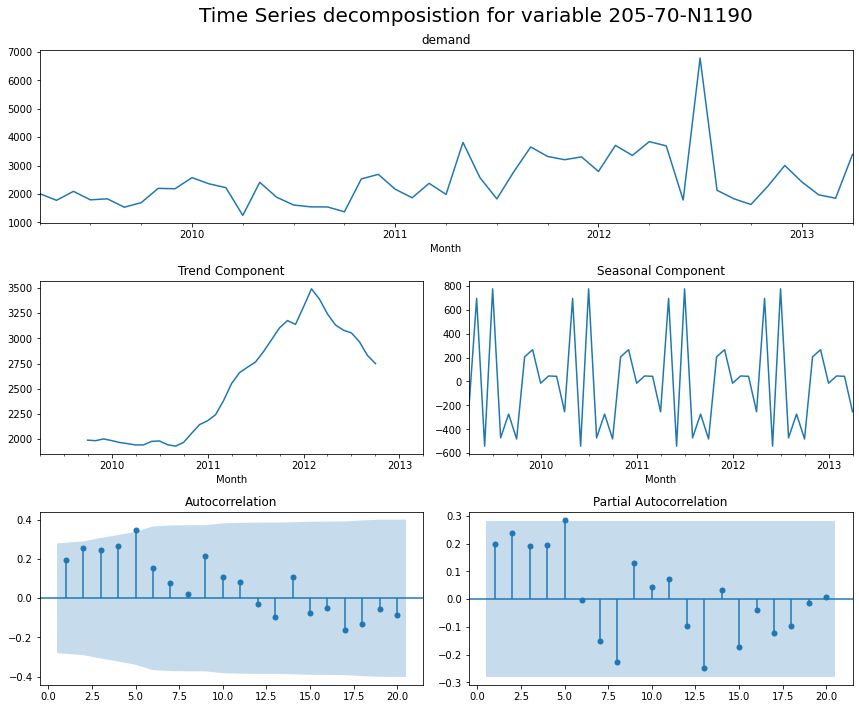

In [15]:
i=0
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- we can see that there is no significant values for lag '1' for the ACF and PACF function. 
- ACF is decreasing after 1st lag term
- From the decomposition we can observe upward trend till start of 2012 and following with a downward trend**

indicating the series is non stationary and we need to address the systematic component before we fit the model

In [16]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 205-70-N1190 variable using PMD lib: before differencing


Statsmodel                   PMD_model  \
                                ADF        KPSS             ADF   
ADF statistic              -5.49932    0.325257             NaN   
conclusion               stationary  stationary  non-stationary   
p-value                 2.08861e-06         0.1        0.476777   
should we difference?         False       False            True   

                                        
                                  KPSS  
ADF statistic                      NaN  
conclusion              not stationary  
p-value                      0.0187062  
should we difference?             True

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident thet the series is non stationary


In [17]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 205-70-N1190:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [18]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on 205-70-N1190?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -6.29223    0.110748         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 3.57603e-08         0.1        0.01         0.1
should we difference?         False       False       False       False

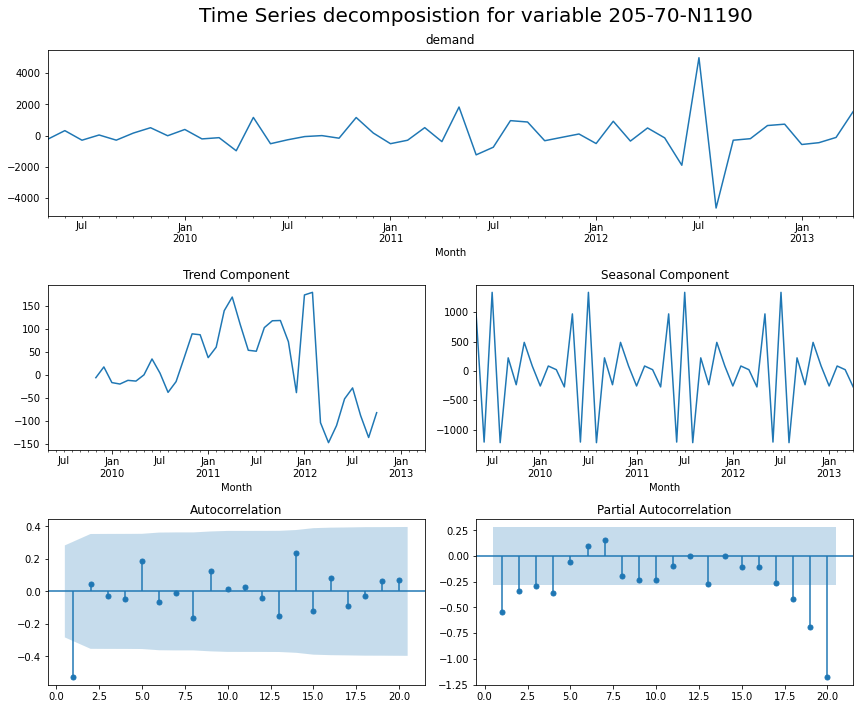

In [19]:
plot_stationarity(df_diff1,20)

**ACF has significant values after first difference is applied at lag ‘1’**

Now the trend component is stationary , what about seasonality ? 

In [20]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]])

time series before differencing on 205-70-N1190 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [21]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on 205-70-N1190 -
recommended order of seasonal differencing : 
OCSB recommendation : 1
nCH recommendation : 0


[None, None, None]

Stationary after 1 round of first-differencing on 205-70-N1190?


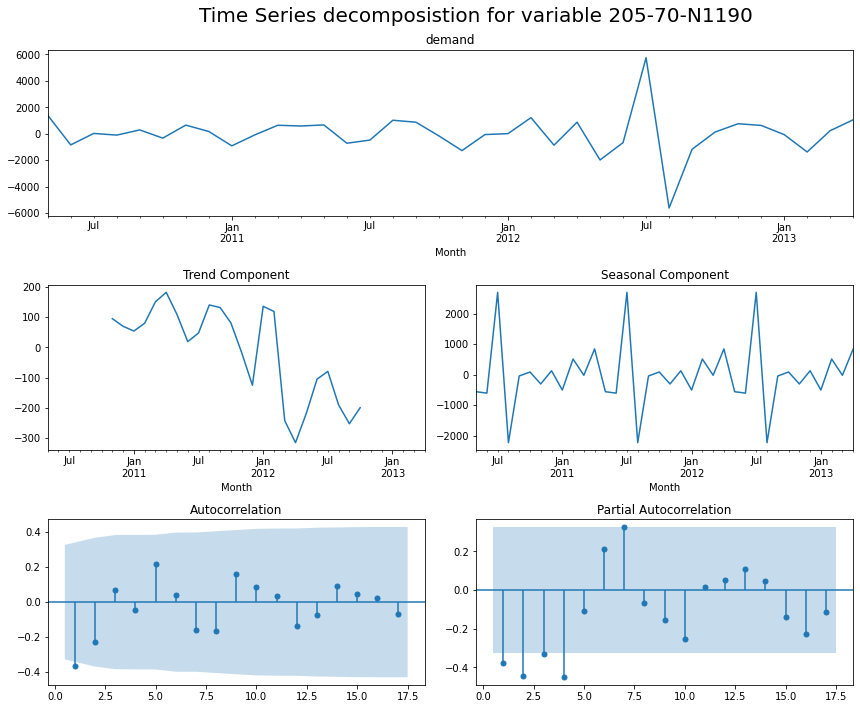

In [22]:
#seasonality differencing
n_diff=12
df_diff1S = df_diff1.diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
plot_stationarity(df_diff1S,17)

In [23]:
stationarity_check(df_diff1S)

Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -5.68741    0.201598         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 8.21843e-07         0.1        0.01         0.1
should we difference?         False       False       False       False

Stationarity check for differenced seasonal data
from the above ACF and PACF plot we can observe the q<=5 from PACF and p=0 from ACF 

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [25]:
best_config,best_RMSE

([None, True, None, 12, True, True], 571.5074946596628)

In [26]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

571.5074946596628 [None, True, None, 12, True, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:       455.667
1                     Mean Squared Error:      2546.046
2                Root Mean Squared Error:       571.507
3         Mean absolute percentage error:        17.437
4  Scaled Mean absolute percentage error:        18.137
5                    Mean forecast error:      2329.589
6          Normalised mean squared error:         0.901
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [27]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred['205-70-N1190'].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred['205-70-N1190'].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var1=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))

error_var1

,Errors,Holts_winter,EWMA 0.17,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,455.667,606.411,455.667,774.938,368.389,667.736
1,Mean Squared Error:,2546.046,2546.046,2546.046,2546.046,2546.046,2546.046
2,Root Mean Squared Error:,571.507,676.444,564.797,950.097,457.664,729.496
3,Mean absolute percentage error:,17.437,27.767,17.636,27.905,14.624,29.957
4,Scaled Mean absolute percentage error:,18.137,23.724,18.142,34.228,14.704,25.777
5,Mean forecast error:,2329.589,2880.233,2356.233,1711.062,2477.798,2936.271
6,Normalised mean squared error:,0.901,1.262,0.880,2.490,0.578,1.468


In [275]:
# grid search ARIMA parameters for time series

series = df_diff1S[:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 1) RMSE=2295.998


predicted=2157.16, expected=-1170.00
predicted=2941.31, expected=132.00
predicted=2486.46, expected=758.00
predicted=579.77, expected=631.00
predicted=-35.72, expected=-62.00
predicted=11.31, expected=-1376.00
predicted=932.22, expected=234.00
predicted=440.56, expected=1058.00
Test RMSE: 1758.780


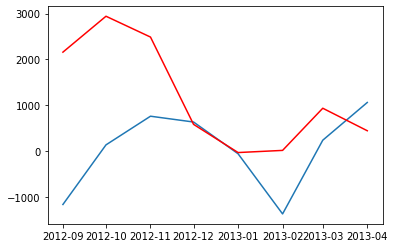

In [28]:
X=df_diff1S
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [29]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -300.040
Date:                Tue, 17 May 2022   AIC                            606.080
Time:                        14:57:24   BIC                            610.746
Sample:                             0   HQIC                           607.691
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.9549     63.824     -0.438      0.661    -153.048      97.138
ma.L1         -0.7286      0.149     -4.881      0.000      -1.021      -0.436
sigma2        1.6e+06   3.13e+05      5.117      0.0

                 0
count    35.000000
mean     37.869386
std    1291.080520
min   -2766.773739
25%    -474.095620
50%     -66.004284
75%     744.603372
max    4606.235429


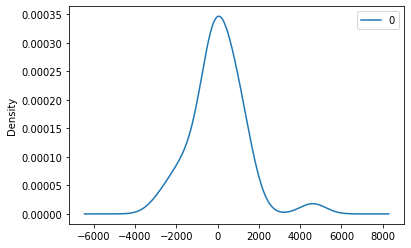

In [30]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

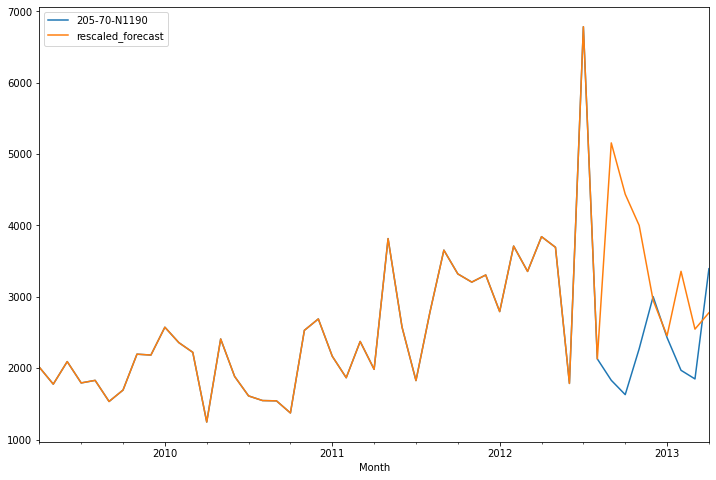

In [31]:
df_var1=pd.DataFrame(df[fc_ls1[i]])
df_var1['diff1']=df_var1.iloc[:,0].diff(1)
df_var1['Sdiff1']=df_var1.iloc[:,0].diff(1).diff(12)
df_var1['forecast']=predictions
df_var1['forecast2']=pd.concat([train,predictions])
#df_var1['rescale_ARIMA']=df_var1['diff1'].cumsum()
df_var1['rescaled_forecast']= df_var1['forecast2']+df_var1['diff1'].shift(12)+df_var1[fc_ls1[i]].shift(1)
df_var1['rescaled_forecast'].iloc[:13]=df_var1[fc_ls1[i]].iloc[:13]
df_var1.drop('forecast2',inplace=True,axis=1)
df_var1
df_var1[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [32]:
error_var1=error_var1.merge(model_eval(df[fc_ls1[i]][size:],df_var1['rescaled_forecast'][size:],'ARIMA'))
error_var1.set_index('Errors',inplace= True)
# multi index columns
error_var1.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var1.columns)])
error_var1

205-70-N1190                      \
                                       Holts_winter EWMA 0.17  EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                        455.667   606.411   455.667   
Mean Squared Error:                        2546.046  2546.046  2546.046   
Root Mean Squared Error:                    571.507   676.444   564.797   
Mean absolute percentage error:              17.437    27.767    17.636   
Scaled Mean absolute percentage error:       18.137    23.724    18.142   
Mean forecast error:                       2329.589  2880.233  2356.233   
Normalised mean squared error:                0.901     1.262     0.880   

                                                                                
                                        EWMA 0.8     SMA-6    SMA-12     ARIMA  
Errors                                                                          
Mean Absolute Error:                     774.938   368.389   667.736   506.924  
Mean Squared Error:                     2546.046  2546.046  2546.046  3186.744  
Root Mean Squared Error:                 950.097   457.664   729.496  1085.543  
Mean absolute percentage error:           27.905    14.624    29.957    26.643  
Scaled Mean absolute percentage error:    34.228    14.704    25.777    16.648  
Mean forecast error:                    1711.062  2477.798  2936.271  3591.454  
Normalised mean squared error:             2.490     0.578     1.468     0.914

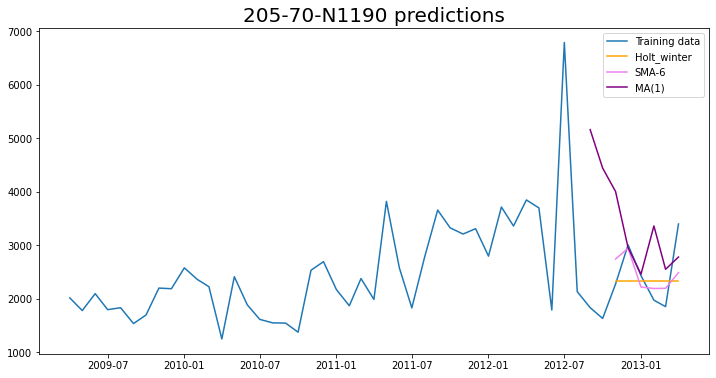

In [102]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
#plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var1['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [103]:
len(predictions)

8

In [33]:
Summary_ls.append('MA(1)')

<div class="alert alert-block alert-danger" >
Here for this variable we can opt for MA(1) as it is performing the well with the test_data (last 8 months ) on the long run this model will perfom better than HW or SMA flat predictions

### Variable2 : PC_198_27_42263 ( var 2)

PC_198_27_42263


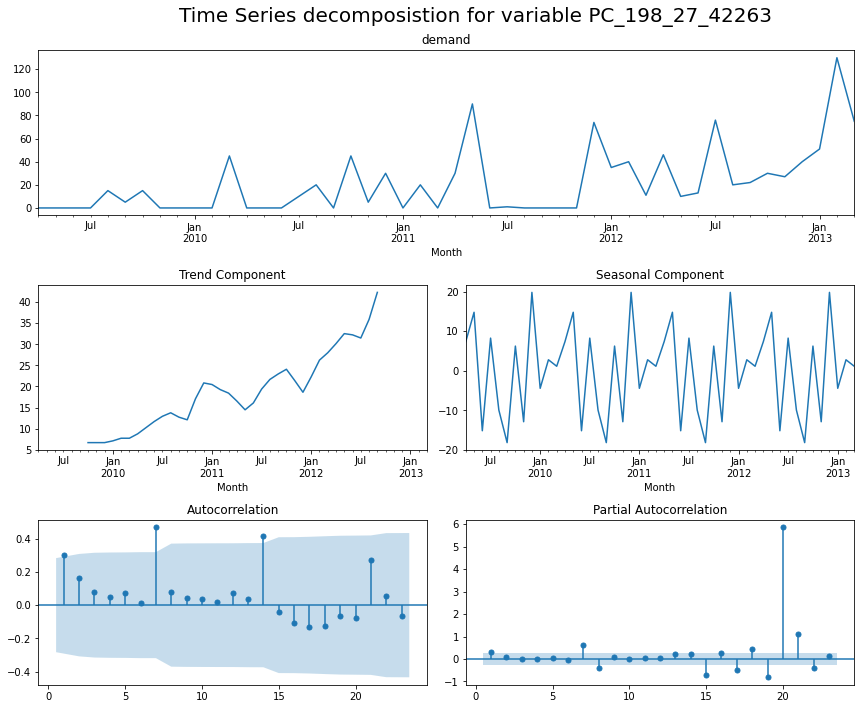

In [35]:
i=1
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],23)

**We can observe a slight trend and seasonality pattern observed, it is a clear indication that the variable is not stationary.**
- ACF, PACF have significant values at lag ‘1’
- ACF reduces significantly after lag ‘1’


##### Stationarity checks and feature engineering for variable 'PC_198_27_42263'

In [122]:
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_198_27_42263 variable using PMD lib: before differencing


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             0.880124        0.546022   
conclusion              non-stationary (unit root)  not stationary   
p-value                                   0.992825       0.0313014   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                      0.0629335            0.01  
should we difference?             True            True

In [123]:

# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print("recommended order of first differencing for original data:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [124]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_198_27_42263?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -7.24752    0.149394         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 1.81584e-10         0.1        0.01         0.1
should we difference?         False       False       False       False

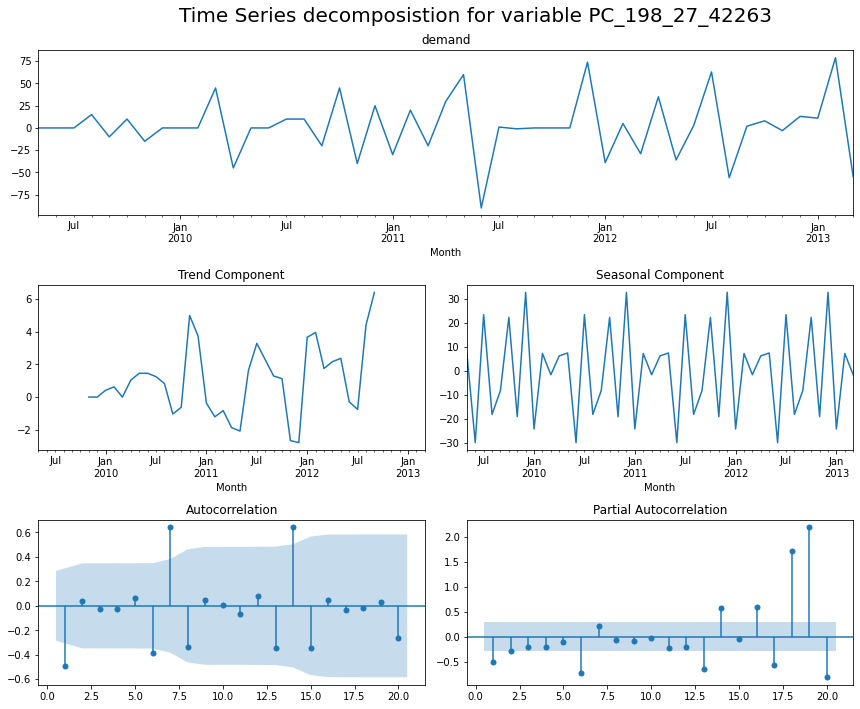

In [125]:
plot_stationarity(df_diff1, 20)

ACF has significant difference at lag ‘1’

**Trend exists in our data**

##### Seasonality test

In [126]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_198_27_42263 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [127]:
# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf = pmd.arima.ndiffs(df_diff1, test="adf")
n_kpss = pmd.arima.ndiffs(df_diff1, test="kpss")
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)
n_ch = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)

print("after 1 round of differencing - do we need more?")
n_diffs = {"recommended additional differencing":"", "ADF first":n_adf, "KPSS first":n_kpss, 
    "OCSB seasonal":n_ocsb, "CH seasonal":n_ch}
[print(key, ":", value) for key,value in n_diffs.items()]

after 1 round of differencing - do we need more?
recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


[None, None, None, None, None]

 **From the seasonality decomposistion, We can see that there is no pattern that is repeated over a period of time. Also from the seasonality differencing check pmd models suggests no seasonal exists.**

In [129]:
best_config,best_RMSE

(['add', False, 'add', 12, False, True], 41.70313744884088)

In [130]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

41.70313744884088 ['add', False, 'add', 12, False, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        29.660
1                     Mean Squared Error:        68.745
2                Root Mean Squared Error:        41.703
3         Mean absolute percentage error:        41.259
4  Scaled Mean absolute percentage error:        51.117
5                    Mean forecast error:        37.961
6          Normalised mean squared error:         1.146
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [131]:
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var2=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [132]:
error_var2

,Errors,Holts_winter,EWMA 0.0,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,29.660,27.988,30.196,30.742,20.917,26.069
1,Mean Squared Error:,68.745,40.060,40.060,40.060,68.745,68.745
2,Root Mean Squared Error:,41.703,39.945,41.301,41.573,34.335,39.886
3,Mean absolute percentage error:,41.259,100.412,113.673,122.146,25.411,33.124
4,Scaled Mean absolute percentage error:,51.117,204.796,342.896,420.890,31.799,42.375
5,Mean forecast error:,37.961,0.537,4.544,5.363,40.911,35.834
6,Normalised mean squared error:,1.146,0.871,0.931,0.943,0.777,1.048


In [133]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 1) RMSE=25.931


predicted=18.29, expected=3.00
predicted=14.44, expected=63.00
predicted=-43.05, expected=-56.00
predicted=12.51, expected=2.00
predicted=10.30, expected=8.00
predicted=2.84, expected=-3.00
predicted=6.05, expected=13.00
predicted=-5.61, expected=11.00
predicted=-14.42, expected=79.00
predicted=-84.67, expected=-55.00
Test RMSE: 35.834


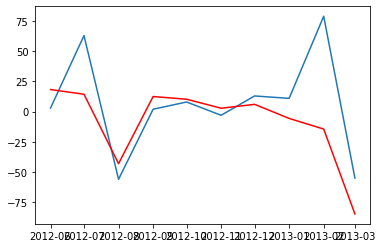

In [135]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [137]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -213.587
Date:                Tue, 17 May 2022   AIC                            433.175
Time:                        08:08:28   BIC                            438.661
Sample:                             0   HQIC                           435.230
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0412      0.531      1.961      0.050       0.000       2.082
ma.L1         -0.9987      5.118     -0.195      0.845     -11.031       9.033
sigma2       581.6962   2909.778      0.200      0.8

               0
count  46.000000
mean   -1.147456
std    24.794734
min   -27.334768
25%   -16.898351
50%    -8.793462
75%     8.182501
max    87.577437


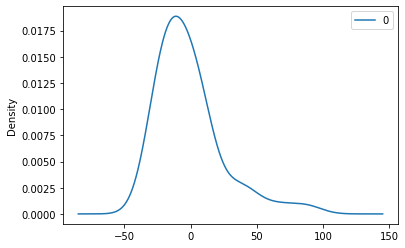

In [138]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

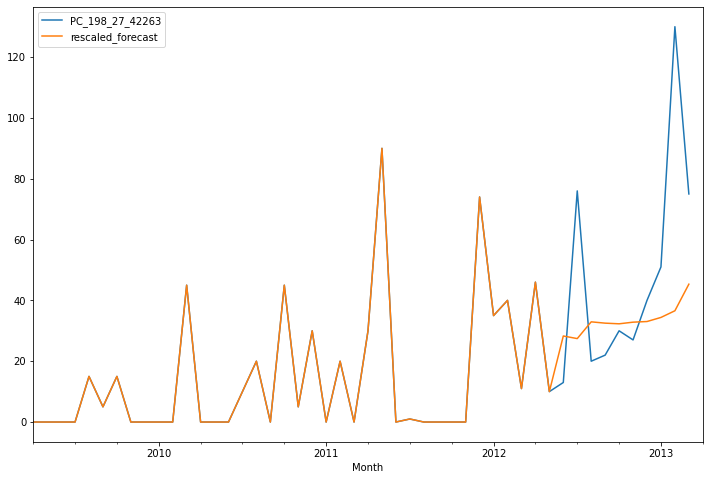

In [139]:
df_var2=pd.DataFrame(df[fc_ls1[i]])
df_var2['diff1']=df_var2.iloc[:,0].diff(1)
#df_var2['Sdiff1']=df_var2.iloc[:,0].diff(1).diff(12)
df_var2['forecast']=predictions
df_var2['forecast2']=pd.concat([train,predictions])
#df_var2['rescale_ARIMA']=df_var2['diff1'].cumsum()
df_var2['rescaled_forecast']= df_var2['forecast2']+df_var2[fc_ls1[i]].shift(1)
df_var2['rescaled_forecast'].iloc[:13]=df_var2[fc_ls1[i]].iloc[:13]
df_var2.drop('forecast2',inplace=True,axis=1)
df_var2
df_var2[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [146]:
error_var2=error_var2.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var2['rescaled_forecast'][-6:-1],'ARIMA'))
error_var2.set_index('Errors',inplace= True)
# multi index columns
error_var2.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var2.columns)])
error_var2

PC_198_27_42263                    \
                                          Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                            29.660   27.988   30.196   
Mean Squared Error:                             68.745   40.060   40.060   
Root Mean Squared Error:                        41.703   39.945   41.301   
Mean absolute percentage error:                 41.259  100.412  113.673   
Scaled Mean absolute percentage error:          51.117  204.796  342.896   
Mean forecast error:                            37.961    0.537    4.544   
Normalised mean squared error:                   1.146    0.871    0.931   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     30.742  20.917  26.069  30.496  
Mean Squared Error:                      40.060  68.745  68.745  74.101  
Root Mean Squared Error:                 41.573  34.335  39.886  44.643  
Mean absolute percentage error:         122.146  25.411  33.124  36.594  
Scaled Mean absolute percentage error:  420.890  31.799  42.375  47.779  
Mean forecast error:                      5.363  40.911  35.834  36.734  
Normalised mean squared error:            0.943   0.777   1.048   1.210

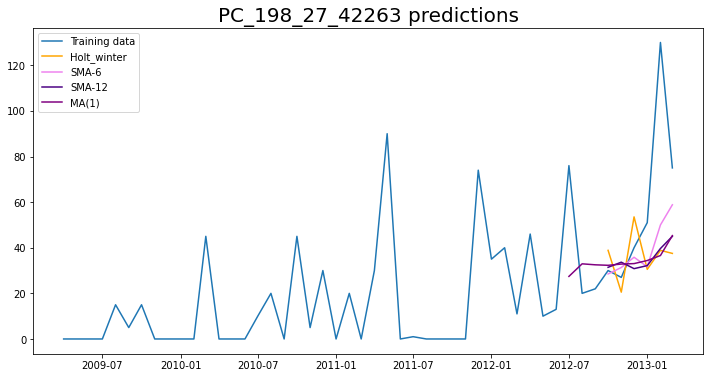

In [148]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var2['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [36]:
Summary_ls.append('SMA-6')

<div class="alert alert-block alert-danger" >
We can conclude that 'SMA-6 with low RMSE and MAPE suits best for 'PC_198_27_42263' variable

### Variable PC_203_32_51461( var 3)

PC_203_32_51461


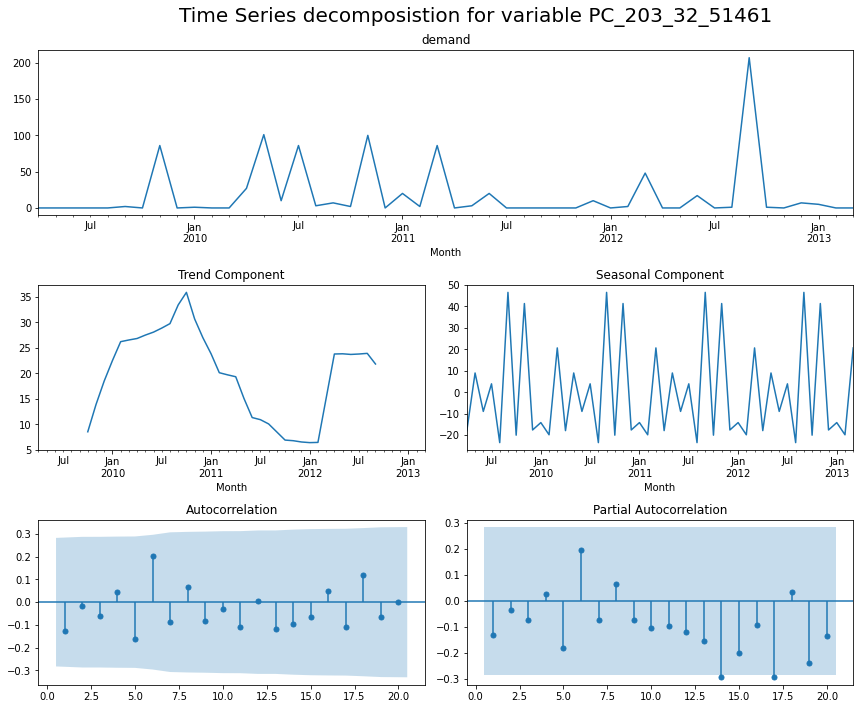

In [151]:
i=2
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

**We can observe that there is no trend and NO seasonality pattern observed, it is a clear indication that the variable is  stationary.**


##### Stationarity checks and feature engineering for variable 'PC_203_32_51461'

In [152]:
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_203_32_51461 variable using PMD lib: before differencing


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -7.64138    0.087969             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 1.89195e-11         0.1       0.0726869         0.1
should we difference?         False       False            True       False

we have conflicting claim of stationarity from pmd model, but the ACF and PACF all lie withing the region except for those further down at 14th lag term, It is highly unlikely that t_1 is highly correlated with t_14. We can conclude that the variable is stationary and we can use a mean model for this variable 

In [153]:
def mean_model(df,column,ma):
    df=df[column].to_frame()
    idx=df.index
    df[f'SMA_{ma}']=df[[df.columns[0]]].rolling(ma, min_periods=1).mean()
    s=df
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot_date(idx,s.iloc[:,0],'v-',color='Orange')
    ax.plot_date(idx,s[f'SMA_{ma}'],'v-',color='green')
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    #ax.set_xlabel('xlabel', fontsize=10)
    ax.set_ylabel('Demand ', fontsize=25)
    ax.set_title(f' Mean model for {fc_ls1[i]}',fontsize=25)
    ax.tick_params(which='minor',labelsize=20)
    ax.tick_params(which='major',labelsize=20)
    plt.legend(labels =list(s.columns), fontsize=14)
    plt.tight_layout()

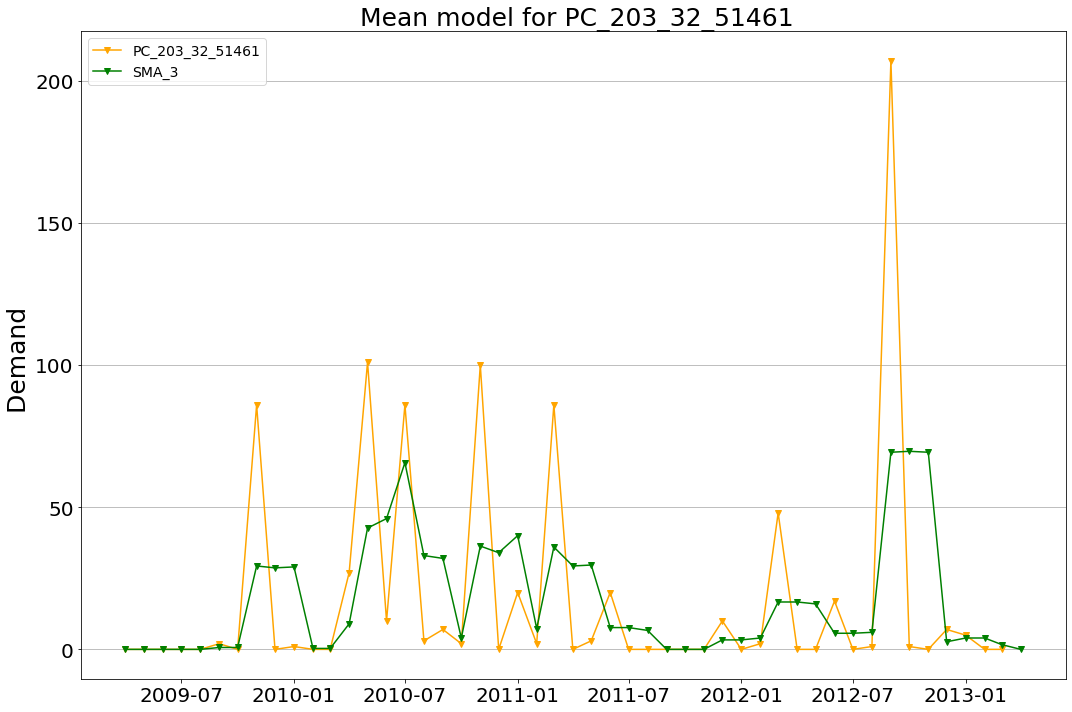

In [154]:
mean_model(df,fc_ls1[i],3)

In [155]:
mean_model_df = df[[fc_ls1[i]]]
mean_model_df[f'SMA_2']=mean_model_df.rolling(2, min_periods=1).mean()
mean_model_df[f'SMA_3']=mean_model_df.iloc[:,0].rolling(3, min_periods=1).mean()
mean_model_df[f'SMA_4']=mean_model_df.iloc[:,0].rolling(4, min_periods=1).mean()
mean_model_df[f'SMA_6']=mean_model_df.iloc[:,0].rolling(6, min_periods=1).mean()
mean_model_df[f'SMA_12']=mean_model_df.iloc[:,0].rolling(12, min_periods=1).mean()


In [156]:
error_var3= model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,1],'SMA_2').\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,2],'SMA_3')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,3],'SMA_4')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,4],'SMA_6')).\
         merge(model_eval(mean_model_df.loc[:,fc_ls1[i]][-6:-1],mean_model_df.iloc[-6:-1,5],'SMA_12'))
error_var3.set_index('Errors',inplace= True)
# multi index columns
error_var3.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var3.columns)])
error_var3

PC_203_32_51461                    \
                                                 SMA_2    SMA_3    SMA_4   
Errors                                                                     
Mean Absolute Error:                             1.500   16.067   21.350   
Mean Squared Error:                              3.847    3.847    3.847   
Root Mean Squared Error:                         1.987   31.131   31.422   
Mean absolute percentage error:                    inf      inf      inf   
Scaled Mean absolute percentage error:         121.212  142.375  159.267   
Mean forecast error:                             3.309   31.142   33.609   
Normalised mean squared error:                   0.350   85.764   87.375   

                                                          
                                          SMA_6   SMA_12  
Errors                                                    
Mean Absolute Error:                     27.467   20.617  
Mean Squared Error:                       3.847    3.847  
Root Mean Squared Error:                 30.405   20.811  
Mean absolute percentage error:             inf      inf  
Scaled Mean absolute percentage error:  177.415  167.896  
Mean forecast error:                     32.926   23.072  
Normalised mean squared error:           81.810   38.326

In [37]:
Summary_ls.append('SMA-2')

<div class="alert alert-block alert-danger" >
for the variable the mean model is most appropriate as there is no trend or seasonality for the data, MA of 2 has the lowest RMSE score

### Variable 4:  PC_600_863_4210

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



PC_600_863_4210


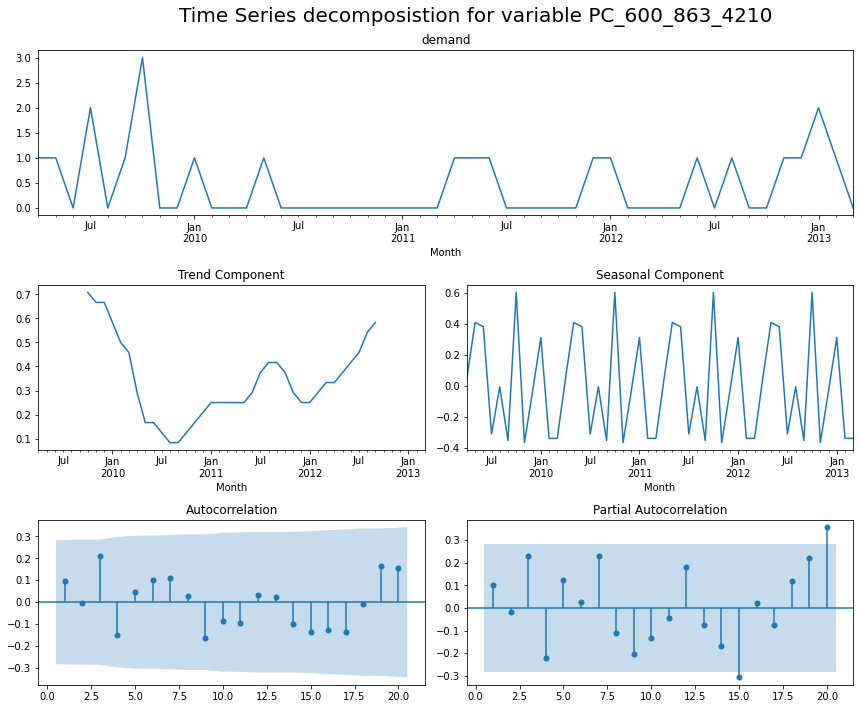

In [158]:
i=3
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the above autocorrelation plots, we see that there is no significant spike at lag 1 in ACF and PACF.

In [159]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_600_863_4210 variable using PMD lib: before differencing


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -6.07985    0.145465             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 1.09886e-07         0.1        0.078477         0.1
should we difference?         False       False            True       False

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident thet the series is non stationary


In [160]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable PC_600_863_4210:
ADF ndiff : 1
KPSS ndiff : 0


[None, None]

In [161]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]][:-1].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_600_863_4210?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -5.66762    0.116399         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 9.07504e-07         0.1        0.01         0.1
should we difference?         False       False       False       False

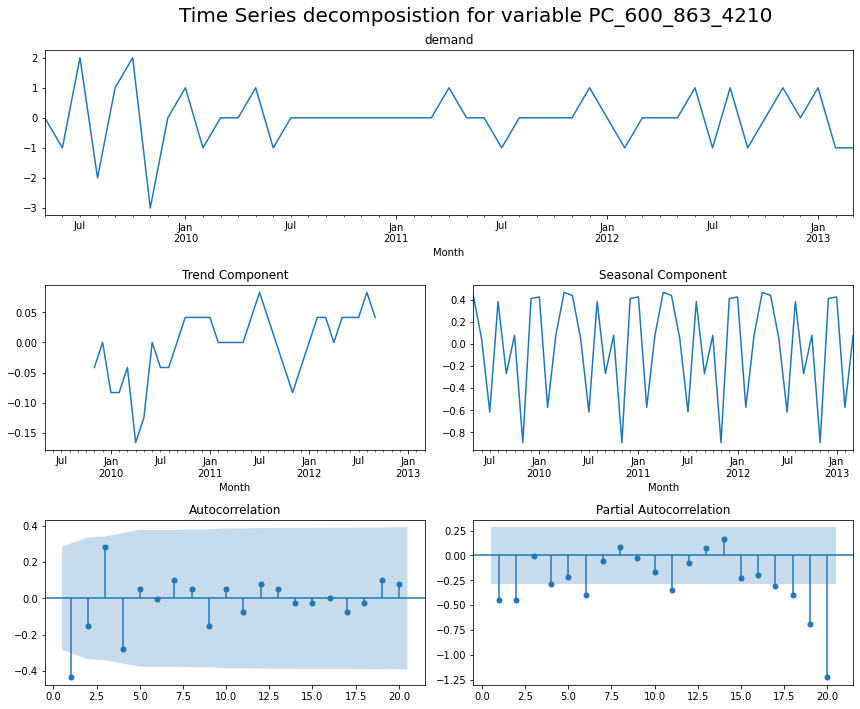

In [162]:
plot_stationarity(df_diff1,20)

**After applying first differencing, the unit root test results become significant, signifying that there is trend in the
series.**

Now the trend component is stationary , what about seasonality ? 

In [163]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_600_863_4210 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [164]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on PC_600_863_4210 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [166]:
best_config,best_RMSE

([None, True, None, 12, False, False], 0.8098738743226855)

In [177]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

0.8098738743226855 [None, True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:         0.698
1                     Mean Squared Error:         1.080
2                Root Mean Squared Error:         0.810
3         Mean absolute percentage error:           inf
4  Scaled Mean absolute percentage error:       131.152
5                    Mean forecast error:         0.405
6          Normalised mean squared error:         1.157
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [178]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var4=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [179]:
error_var4

,Errors,Holts_winter,EWMA 0.0,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,0.698,0.675,0.742,0.889,0.583,0.667
1,Mean Squared Error:,1.080,0.816,0.816,0.816,1.080,1.080
2,Root Mean Squared Error:,0.810,0.817,0.847,1.053,0.670,0.770
3,Mean absolute percentage error:,inf,inf,inf,inf,inf,inf
4,Scaled Mean absolute percentage error:,131.152,200.159,214.222,412.120,105.645,122.890
5,Mean forecast error:,0.405,0.024,0.225,0.666,0.670,0.481
6,Normalised mean squared error:,1.157,0.834,0.897,1.387,0.792,1.046


In [180]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(8, 0, 2) RMSE=0.422


predicted=0.28, expected=1.00
predicted=-0.30, expected=-1.00
predicted=0.58, expected=1.00
predicted=-0.49, expected=-1.00
predicted=-0.68, expected=0.00
predicted=0.14, expected=1.00
predicted=-0.98, expected=0.00
predicted=-0.08, expected=1.00
predicted=-0.47, expected=-1.00
predicted=0.04, expected=-1.00
Test RMSE: 0.784


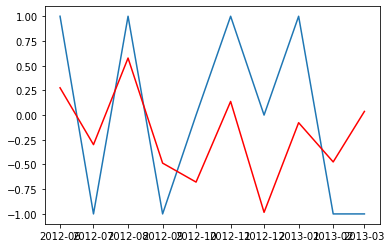

In [181]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(8,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [182]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(8, 0, 2)   Log Likelihood                 -40.841
Date:                Tue, 17 May 2022   AIC                            105.682
Time:                        08:29:46   BIC                            127.625
Sample:                             0   HQIC                           113.902
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.039     -0.068      0.945      -0.080       0.075
ar.L1         -0.0638      0.430     -0.148      0.882      -0.907       0.779
ar.L2         -0.7702      0.370     -2.083      0.0

               0
count  46.000000
mean    0.016249
std     0.625355
min    -1.350520
25%    -0.411306
50%    -0.029413
75%     0.469992
max     1.719076


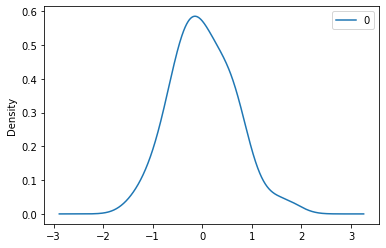

In [183]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

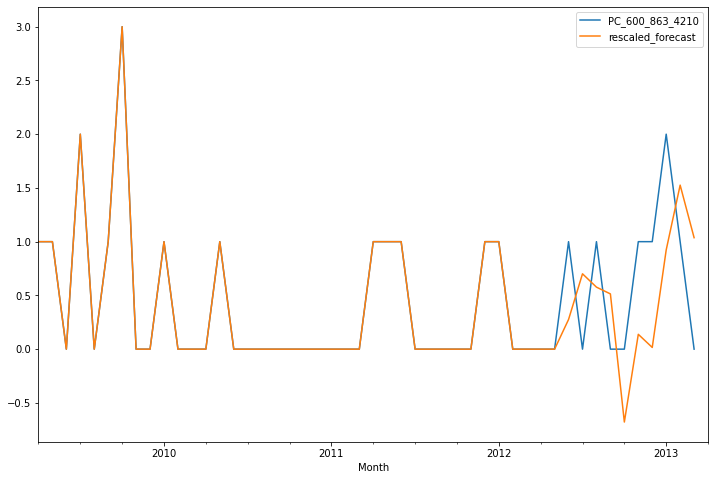

In [184]:
df_var4=pd.DataFrame(df[fc_ls1[i]])
df_var4['diff1']=df_var4.iloc[:,0].diff(1)
#df_var4['Sdiff1']=df_var4.iloc[:,0].diff(1).diff(12)
df_var4['forecast']=predictions
df_var4['forecast2']=pd.concat([train,predictions])
#df_var4['rescale_ARIMA']=df_var4['diff1'].cumsum()
df_var4['rescaled_forecast']= df_var4['forecast2']+df_var4[fc_ls1[i]].shift(1)
df_var4['rescaled_forecast'].iloc[:13]=df_var4[fc_ls1[i]].iloc[:13]
df_var4.drop('forecast2',inplace=True,axis=1)
df_var4
df_var4[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [185]:
error_var4=error_var4.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var4['rescaled_forecast'][-6:-1],'ARIMA'))
error_var4.set_index('Errors',inplace= True)
# multi index columns
error_var4.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var4.columns)])
error_var4

PC_600_863_4210                    \
                                          Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                             0.698    0.675    0.742   
Mean Squared Error:                              1.080    0.816    0.816   
Root Mean Squared Error:                         0.810    0.817    0.847   
Mean absolute percentage error:                    inf      inf      inf   
Scaled Mean absolute percentage error:         131.152  200.159  214.222   
Mean forecast error:                             0.405    0.024    0.225   
Normalised mean squared error:                   1.157    0.834    0.897   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                      0.889    0.583    0.667    0.897  
Mean Squared Error:                       0.816    1.080    1.080    1.183  
Root Mean Squared Error:                  1.053    0.670    0.770    0.919  
Mean absolute percentage error:             inf      inf      inf      inf  
Scaled Mean absolute percentage error:  412.120  105.645  122.890  132.107  
Mean forecast error:                      0.666    0.670    0.481    0.925  
Normalised mean squared error:            1.387    0.792    1.046    1.689

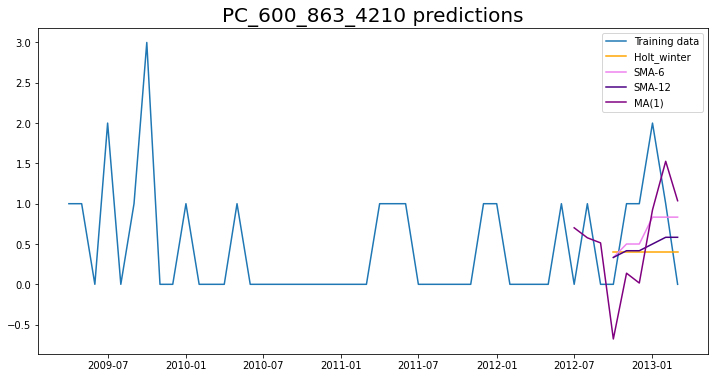

In [188]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var4['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [38]:
Summary_ls.append('AR(8) and MA(2)')

<div class="alert alert-block alert-danger" >
For the variable 'PC_600_863_4210' we could achieve lower RMSE with AR of 8 and MA of 2 , we can conclude tht ARMA model works well for the variable

### Variable 5:  PC_6735_61_3410

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



PC_6735_61_3410


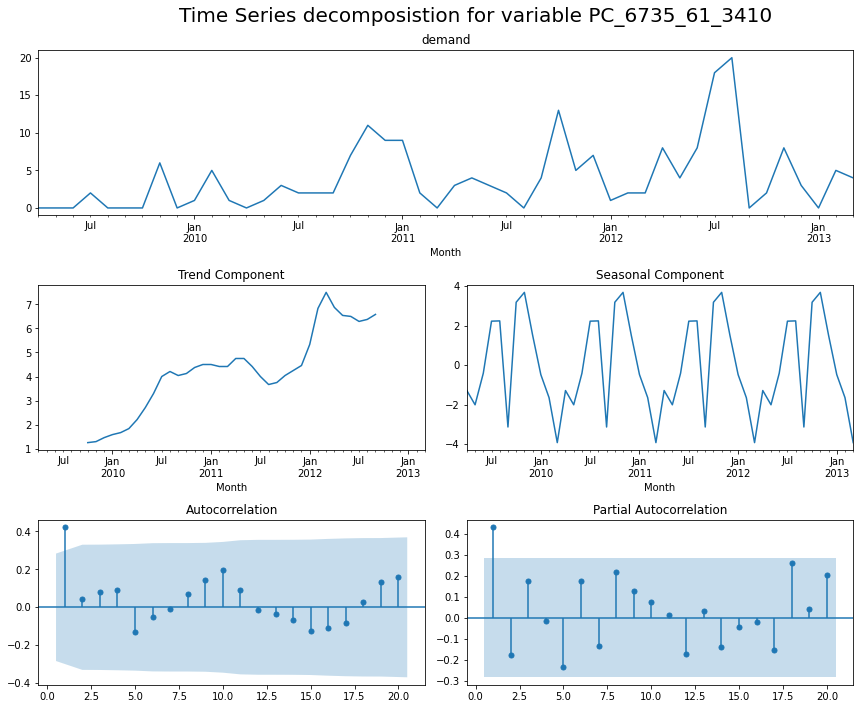

In [201]:
i=4
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]][:-1],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the autocorrelation plots, we see that there is a significant spike at lag 1 in ACF and PACF which shows there could be trend in the series and there doesn’t appear to be any significant spikes at lag S (signifying no trace of seasonality in the series).

In [202]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} variable using PMD lib: before differencing")
stationarity_check(df[fc_ls1[i]][:-1])

Stationarity test results for original data on PC_6735_61_3410 variable using PMD lib: before differencing


Statsmodel                   PMD_model  \
                                ADF        KPSS             ADF   
ADF statistic               -4.3169    0.406281             NaN   
conclusion               stationary  stationary  non-stationary   
p-value                 0.000415205    0.074448       0.0991003   
should we difference?         False       False            True   

                                        
                                  KPSS  
ADF statistic                      NaN  
conclusion              not stationary  
p-value                      0.0477593  
should we difference?             True

we have conflicting hypothesis test report from pmd module and stats module, but from the plots it is clearly evident that the series is non stationary


In [203]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]][:-1], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable PC_6735_61_3410:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [204]:
# ADF and KPSS tests after differencing:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]][:-1].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on PC_6735_61_3410?


Statsmodel               PMD_model            
                                ADF        KPSS         ADF        KPSS
ADF statistic              -4.31168    0.145052         NaN         NaN
conclusion               stationary  stationary  stationary  stationary
p-value                 0.000423972         0.1   0.0182342         0.1
should we difference?         False       False       False       False

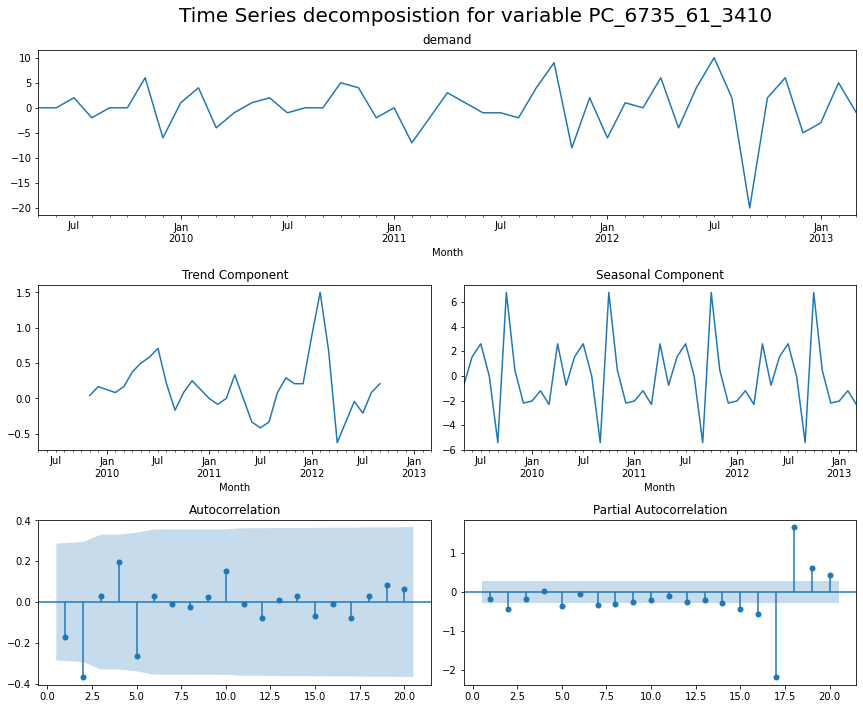

In [205]:
plot_stationarity(df_diff1,20)

**After applying first differencing, the unit root test results become significant, signifying that there is trend in the
series.**

Now the trend component is stationary , what about seasonality ? 

In [206]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on PC_6735_61_3410 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [207]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on PC_6735_61_3410 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

Single Exponential smoothing is appropriate for a stable time series- one that exhibits no significant trend, cyclical, or seasonal effects-- because the use the previous movement they adapt to changes in the time series. This technique generally forecasts well with de-seasonalized monthly data

when yearly data are analyzed, single exponential smoothing often **does not do as well as** the Holt-Winter methods, where trend and seasonality may be involved

In [208]:
best_config,best_RMSE

([None, True, None, 12, False, False], 5.025568055570011)

In [209]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

5.025568055570011 [None, True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:         4.363
1                     Mean Squared Error:         4.435
2                Root Mean Squared Error:         5.026
3         Mean absolute percentage error:           inf
4  Scaled Mean absolute percentage error:        87.550
5                    Mean forecast error:         8.029
6          Normalised mean squared error:         3.383
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [210]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var5=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [211]:
error_var5

,Errors,Holts_winter,EWMA 0.0,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,4.363,3.667,6.447,16.005,3.556,3.250
1,Mean Squared Error:,4.435,4.082,4.082,4.082,4.435,4.435
2,Root Mean Squared Error:,5.026,4.082,7.602,16.504,4.298,3.670
3,Mean absolute percentage error:,inf,100.000,231.218,613.519,inf,inf
4,Scaled Mean absolute percentage error:,87.550,200.000,2354.129,253.699,82.455,78.441
5,Mean forecast error:,8.029,0.000,5.780,15.338,6.918,6.474
6,Normalised mean squared error:,3.383,0.856,2.969,13.992,2.474,1.804


In [213]:
# grid search ARIMA parameters for time series

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 2) RMSE=6.279


predicted=0.81, expected=4.00
predicted=-1.13, expected=10.00
predicted=-6.68, expected=2.00
predicted=-7.60, expected=-20.00
predicted=3.47, expected=2.00
predicted=5.29, expected=6.00
predicted=0.25, expected=-5.00
predicted=2.51, expected=-3.00
predicted=4.81, expected=5.00
predicted=2.24, expected=-1.00
Test RMSE: 6.590


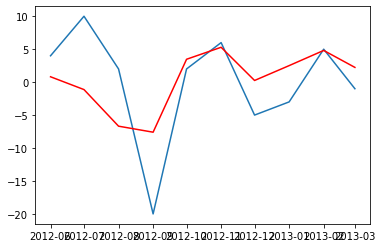

In [214]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [215]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -129.285
Date:                Tue, 17 May 2022   AIC                            266.570
Time:                        08:42:34   BIC                            273.884
Sample:                             0   HQIC                           269.310
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1345      0.077      1.741      0.082      -0.017       0.286
ma.L1         -0.5578     34.046     -0.016      0.987     -67.287      66.172
ma.L2         -0.4419     15.212     -0.029      0.9

               0
count  46.000000
mean    0.141695
std     3.992883
min   -10.860846
25%    -2.224888
50%    -0.157757
75%     2.561348
max    10.370257


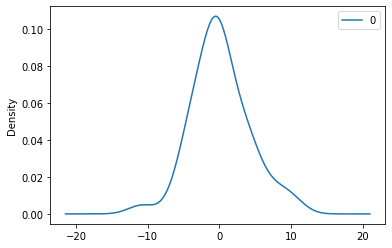

In [216]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

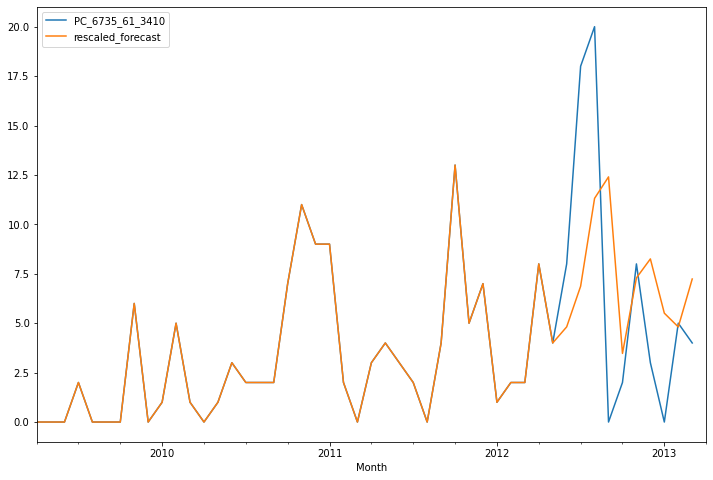

In [217]:
df_var5=pd.DataFrame(df[fc_ls1[i]])
df_var5['diff1']=df_var5.iloc[:,0].diff(1)
#df_var5['Sdiff1']=df_var5.iloc[:,0].diff(1).diff(12)
df_var5['forecast']=predictions
df_var5['forecast2']=pd.concat([train,predictions])
#df_var5['rescale_ARIMA']=df_var5['diff1'].cumsum()
df_var5['rescaled_forecast']= df_var5['forecast2']+df_var5[fc_ls1[i]].shift(1)
df_var5['rescaled_forecast'].iloc[:13]=df_var5[fc_ls1[i]].iloc[:13]
df_var5.drop('forecast2',inplace=True,axis=1)
df_var5
df_var5[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [218]:
error_var5=error_var5.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var5['rescaled_forecast'][-6:-1],'ARIMA'))
error_var5.set_index('Errors',inplace= True)
# multi index columns
error_var5.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var5.columns)])
error_var5

PC_6735_61_3410                     \
                                          Holts_winter EWMA 0.0  EWMA 0.4   
Errors                                                                      
Mean Absolute Error:                             4.363    3.667     6.447   
Mean Squared Error:                              4.435    4.082     4.082   
Root Mean Squared Error:                         5.026    4.082     7.602   
Mean absolute percentage error:                    inf  100.000   231.218   
Scaled Mean absolute percentage error:          87.550  200.000  2354.129   
Mean forecast error:                             8.029    0.000     5.780   
Normalised mean squared error:                   3.383    0.856     2.969   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     16.005   3.556   3.250   2.979  
Mean Squared Error:                       4.082   4.435   4.435   4.775  
Root Mean Squared Error:                 16.504   4.298   3.670   3.713  
Mean absolute percentage error:         613.519     inf     inf     inf  
Scaled Mean absolute percentage error:  253.699  82.455  78.441  72.819  
Mean forecast error:                     15.338   6.918   6.474   6.739  
Normalised mean squared error:           13.992   2.474   1.804   1.622

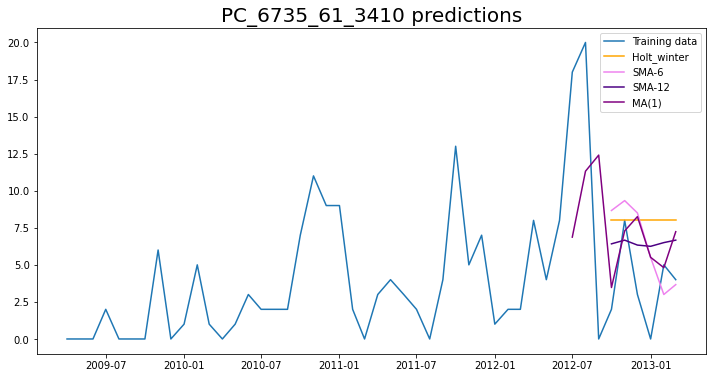

In [219]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var5['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [39]:
Summary_ls.append('ARMA(8)')

<div class="alert alert-block alert-danger" >
For the variable 'PC_6735_61_3410' we could achieve lower RMSE of 3.7 with  AR(0) and MA(8) of alpha 0.8 

### Variable 6:  D30141135

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



D30141135


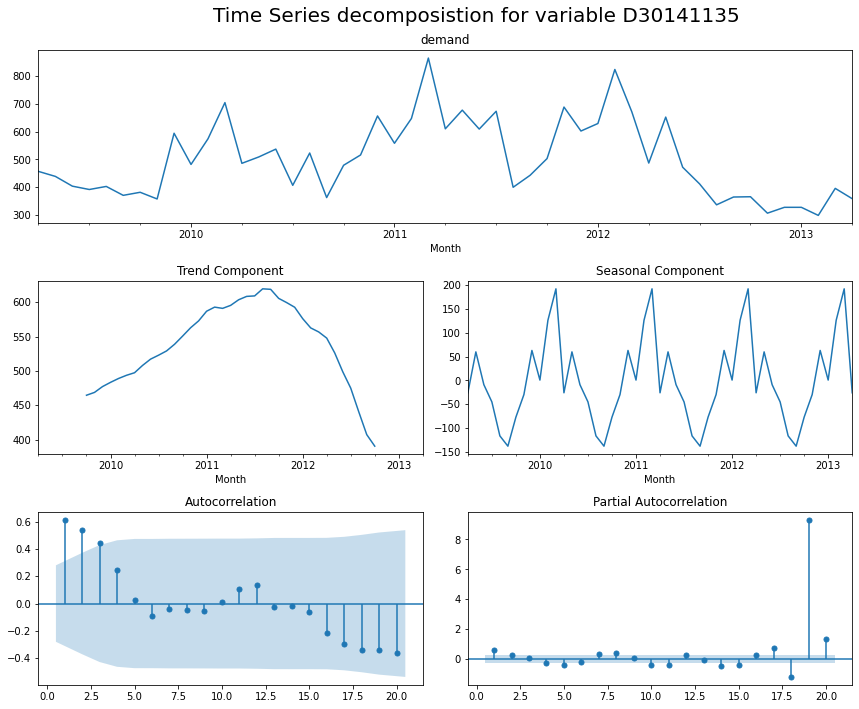

In [287]:
i=5
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the pattern observed above, Trend and Seasonality seems to be missing.
- Checking the other parameters to validate the same. 
- Viewing the Autocorrelation Plots before any differencing is applied. ACF plot seems to be gradually decreasing. 
- ACF and PACF have significant lag 1 valuee. 
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [222]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]}")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on D30141135


Statsmodel              \
                                               ADF        KPSS   
ADF statistic                             -1.12681    0.154822   
conclusion              non-stationary (unit root)  stationary   
p-value                                   0.704261         0.1   
should we difference?                         True       False   

                             PMD_model              
                                   ADF        KPSS  
ADF statistic                      NaN         NaN  
conclusion              non-stationary  stationary  
p-value                       0.552942         0.1  
should we difference?             True       False

we have conflicting hypothesis test report from   at ADF test from pmd module and stats module, but from the plots it is clearly evident that the series is non stationary


In [295]:
# ADF and KPSS tests after differencing:

n_diff = 1
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1 round of first-differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1 round of first-differencing on D30141135?


Statsmodel                   PMD_model            
                                ADF        KPSS             ADF        KPSS
ADF statistic              -4.62854     0.22552             NaN         NaN
conclusion               stationary  stationary  non-stationary  stationary
p-value                 0.000114398         0.1        0.184397         0.1
should we difference?         False       False            True       False

After first differencing the varible is still not stationary this could be spurious as the data looks stationary lets look at the plot

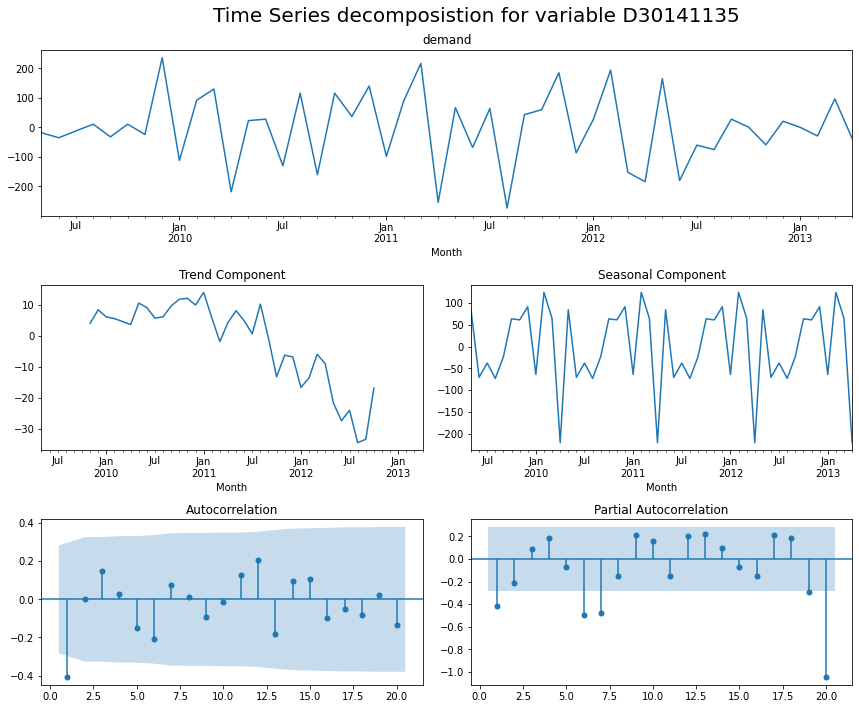

In [250]:
plot_stationarity(df_diff1,20)

The ACF now has few significant values after first differencing.

what about seasonality ? 

In [251]:
print(f"time series before differencing on {fc_ls1[i]} -")
seasonality_recomendation(df[fc_ls1[i]][:-1])

time series before differencing on D30141135 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [252]:
print(f"time series after differencing on {fc_ls1[i]} -")
seasonality_recomendation(df_diff1)

time series after differencing on D30141135 -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**there is no recomendation for seasonal differencing, and we can conclude that there is no seasonality in our differenced data.
Since the time series is a Non Stationary Time Series, we will be applying grid search ARMA(p,q) models.**

we would try:
- various combinations of trend(t), drift(d), stochastic(s), rho (p),beta (b) and error (r) parameters of Exponential soothing model that fits our data best
- various combinations of p and q to see the best ARMA model that fits our data 

### forecasts for variable D30141135

In [288]:
cfg_list = exp_smoothing_configs(seasonal=[0])

In [290]:
best_RMSE,best_config

(39.5501319316505, ['add', False, None, 0, False, True])

In [291]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df[fc_ls1[i]].copy(), pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

39.5501319316505 ['add', False, None, 0, False, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        36.376
1                     Mean Squared Error:       337.766
2                Root Mean Squared Error:        39.550
3         Mean absolute percentage error:        11.095
4  Scaled Mean absolute percentage error:        10.630
5                    Mean forecast error:       353.911
6          Normalised mean squared error:         1.209
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [292]:
#EWMA fit on stationary data
df_pass_pred=df_pass_pred[:-1]
model2 = SimpleExpSmoothing(df_diff1[:-6]).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(df_diff1[:-6]).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(df_diff1[-6:], predictions4,'EWMA'+' '+alpha))
var_ldf
#fit SMA ON ORIGINAL DATA
df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var6=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))

In [293]:
error_var6

,Errors,Holts_winter,EWMA 0.0,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,36.376,40.500,40.500,41.266,44.056,132.153
1,Mean Squared Error:,337.766,50.894,50.894,50.894,339.016,339.016
2,Root Mean Squared Error:,39.550,50.890,53.208,50.998,49.509,147.233
3,Mean absolute percentage error:,11.095,inf,inf,inf,12.966,40.656
4,Scaled Mean absolute percentage error:,10.630,198.509,415.363,204.733,12.366,32.502
5,Mean forecast error:,353.911,2.166,16.732,2.297,363.565,472.113
6,Normalised mean squared error:,1.209,0.834,0.911,0.837,1.795,15.876


In [296]:
# grid search diffrenced data for ARIMA parameters
series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(6, 1, 2) RMSE=104.321


for the differenced data the model is suggesting one more differencing , but before we do that let us check for the original variable, what p,d,q values the grid search suggests

In [267]:
# grid search ARIMA parameters for time series

series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(6, 0, 2) RMSE=107.787


on the original data the grid search is suggesting no more differencing and the data is stationary. From this we can conclude the data is stationary

predicted=502.53, expected=412.00
predicted=429.76, expected=337.00
predicted=390.67, expected=365.00
predicted=375.46, expected=366.00
predicted=393.75, expected=307.00
predicted=438.37, expected=328.00
predicted=435.38, expected=328.00
predicted=385.86, expected=299.00
predicted=323.97, expected=396.00
predicted=402.26, expected=359.00
Test RMSE: 79.617


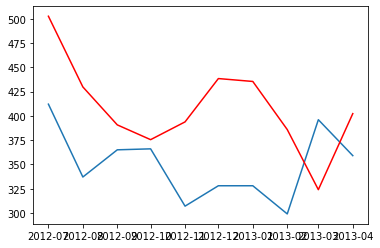

In [297]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(6,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [298]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(6, 0, 2)   Log Likelihood                -282.175
Date:                Tue, 17 May 2022   AIC                            584.349
Time:                        09:35:42   BIC                            603.061
Sample:                             0   HQIC                           591.421
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        504.0898     44.953     11.214      0.000     415.984     592.196
ar.L1          0.6951      0.196      3.540      0.000       0.310       1.080
ar.L2         -0.4512      0.280     -1.613      0.1

                0
count   48.000000
mean    -0.025324
std     85.602337
min   -148.517707
25%    -62.006926
50%    -21.033332
75%     49.034818
max    229.409062


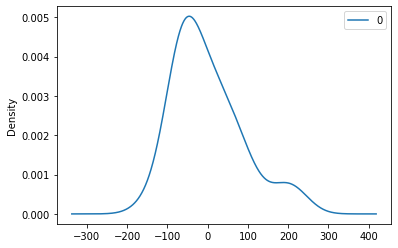

In [299]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

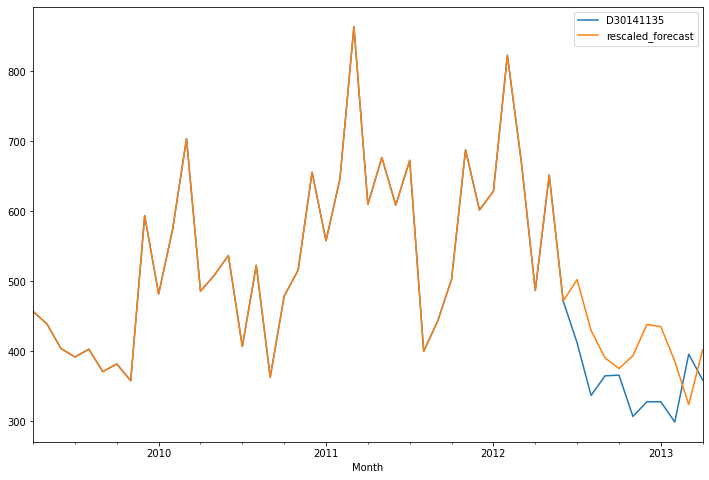

In [300]:
df_var6=pd.DataFrame(df[fc_ls1[i]])
#df_var6['diff1']=df_var6.iloc[:,0].diff(1)
#df_var6['Sdiff1']=df_var6.iloc[:,0].diff(1).diff(12)
df_var6['forecast']=predictions
df_var6['forecast2']=pd.concat([train,predictions])
#df_var6['rescale_ARIMA']=df_var6['diff1'].cumsum()
df_var6['rescaled_forecast']= df_var6['forecast2']#+df_var6[fc_ls1[i]].shift(1)
#df_var6['rescaled_forecast'].iloc[:13]=df_var6[fc_ls1[i]].iloc[:13]
df_var6.drop('forecast2',inplace=True,axis=1)
df_var6
df_var6[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [301]:
error_var6=error_var6.merge(model_eval(df[fc_ls1[i]][-6:],df_var6['rescaled_forecast'][-6:],'ARIMA'))
error_var6.set_index('Errors',inplace= True)
# multi index columns
error_var6.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var6.columns)])
error_var6

D30141135                    \
                                       Holts_winter EWMA 0.0 EWMA 0.4   
Errors                                                                  
Mean Absolute Error:                         36.376   40.500   40.500   
Mean Squared Error:                         337.766   50.894   50.894   
Root Mean Squared Error:                     39.550   50.890   53.208   
Mean absolute percentage error:              11.095      inf      inf   
Scaled Mean absolute percentage error:       10.630  198.509  415.363   
Mean forecast error:                        353.911    2.166   16.732   
Normalised mean squared error:                1.209    0.834    0.911   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     41.266   44.056  132.153   84.442  
Mean Squared Error:                      50.894  339.016  339.016  337.766  
Root Mean Squared Error:                 50.998   49.509  147.233   87.409  
Mean absolute percentage error:             inf   12.966   40.656   25.656  
Scaled Mean absolute percentage error:  204.733   12.366   32.502   23.073  
Mean forecast error:                      2.297  363.565  472.113  398.418  
Normalised mean squared error:            0.837    1.795   15.876    5.907

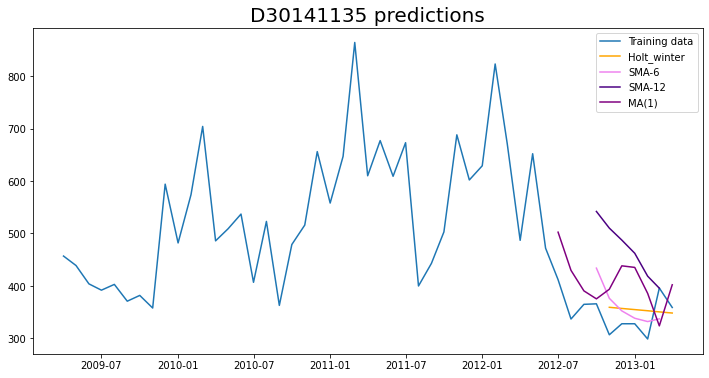

In [302]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var6['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [40]:
Summary_ls.append('AR(6) and MA(2)')

<div class="alert alert-block alert-danger" >
For the variable 'D30141135' we could achieve lower RMSE with  Holts-winter model, or AR(6) and MA(2) we can conclude tht either of models works well for the variable. HW is more flat predictions than ARMA, And It can be seen that the demand is likely to be dropping in the near future for the spare part D30141135.

### Variable 7:  600-181-6740I.

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



600-181-6740I.


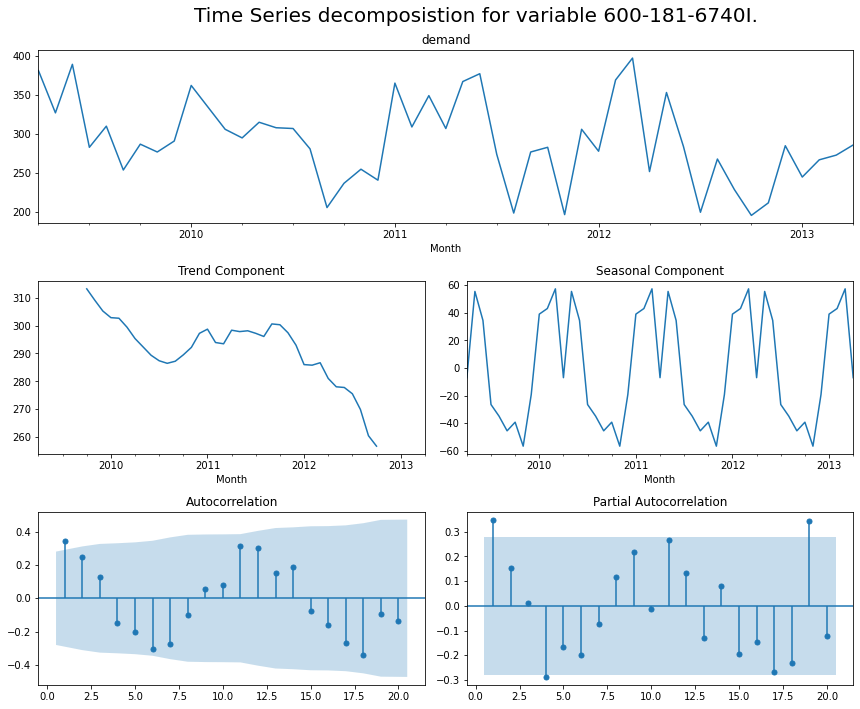

In [307]:
i=6
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Viewing the Autocorrelation Plots before any differencing is applied. ACF plot seems to be gradually decreasing. 
- ACF and PACF have significant lag 1 values. 
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [308]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 600-181-6740I. 


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -4.92165    0.449911         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 3.1644e-05   0.0556419   0.0301034         0.1
should we difference?        False       False       False       False

In [309]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 600-181-6740I.:
ADF ndiff : 0
KPSS ndiff : 0


[None, None]

From the hypothesis test report from pmd and stats module, there is no trend in the variable '600-181-6740I.'

What about seasonality ?

In [310]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series after first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series after first differencing for 600-181-6740I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After stationarity checks with respect to trend and seasonality, it is found the varibale '600-181-6740I.' is found to be stationary.**


### Forecasting for variable '600-181-6740I.'

In [311]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [314]:
best_RMSE,best_config

(35.091890815503994, ['add', True, None, 12, True, False])

In [315]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

35.091890815503994 ['add', True, None, 12, True, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        23.988
1                     Mean Squared Error:       262.618
2                Root Mean Squared Error:        35.092
3         Mean absolute percentage error:        10.369
4  Scaled Mean absolute percentage error:         9.270
5                    Mean forecast error:       284.962
6          Normalised mean squared error:         1.525
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [316]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var7=var_ldf.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(df_pass_pred[fc_ls1[i]][-6:], df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var7

,Errors,Holts_winter,EWMA 0.46,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,23.988,41.279,37.792,57.566,26.333,25.125
1,Mean Squared Error:,262.618,262.618,262.618,262.618,262.618,262.618
2,Root Mean Squared Error:,35.092,45.394,41.209,63.140,29.895,32.785
3,Mean absolute percentage error:,10.369,15.209,14.008,21.168,9.862,10.482
4,Scaled Mean absolute percentage error:,9.270,16.639,15.116,24.177,10.366,9.784
5,Mean forecast error:,284.962,224.081,229.313,203.768,241.716,268.306
6,Normalised mean squared error:,1.525,2.552,2.103,4.937,1.107,1.331


In [317]:
# grid search ARIMA parameters for time series

series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 3,4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(3, 0, 2) RMSE=62.806


predicted=282.02, expected=200.00
predicted=312.14, expected=268.00
predicted=250.21, expected=229.00
predicted=280.60, expected=196.00
predicted=279.67, expected=212.00
predicted=288.55, expected=285.00
predicted=287.62, expected=245.00
predicted=330.21, expected=267.00
predicted=338.20, expected=273.00
predicted=328.61, expected=286.00
Test RMSE: 57.232


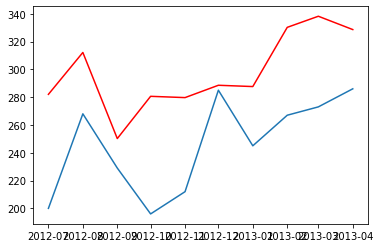

In [318]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [319]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -250.241
Date:                Tue, 17 May 2022   AIC                            514.483
Time:                        09:46:39   BIC                            527.581
Sample:                             0   HQIC                           519.433
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.6399      7.511     38.562      0.000     274.919     304.361
ar.L1          1.7072      0.265      6.439      0.000       1.188       2.227
ar.L2         -0.9816      0.436     -2.254      0.0

               0
count  48.000000
mean    1.503563
std    45.097008
min   -88.722597
25%   -33.272281
50%     3.478045
75%    27.468288
max    91.360122


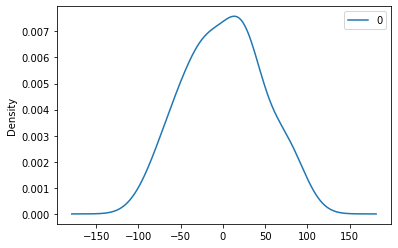

In [320]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

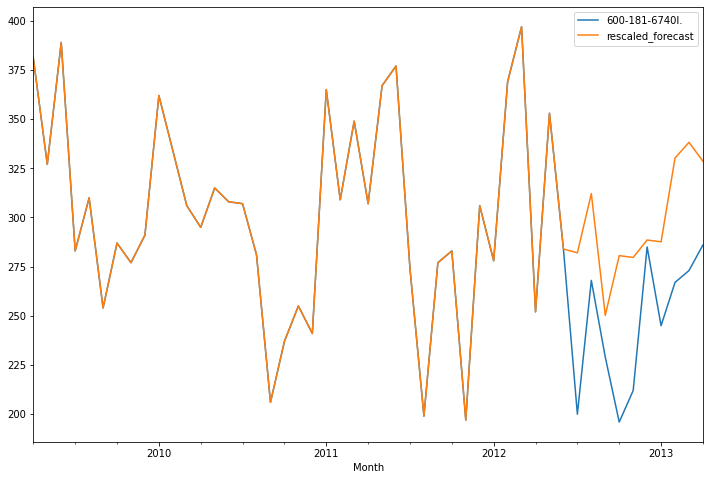

In [322]:
df_var7=pd.DataFrame(df[fc_ls1[i]])
#df_var7['diff1']=df_var7.iloc[:,0].diff(1)
#df_var7['Sdiff1']=df_var7.iloc[:,0].diff(1).diff(12)
df_var7['forecast']=predictions
df_var7['forecast2']=pd.concat([train,predictions])
#df_var7['rescale_ARIMA']=df_var7['diff1'].cumsum()
df_var7['rescaled_forecast']= df_var7['forecast2']#+df_var7[fc_ls1[i]].shift(1)
#df_var7['rescaled_forecast'].iloc[:13]=df_var7[fc_ls1[i]].iloc[:13]
df_var7.drop('forecast2',inplace=True,axis=1)
df_var7
df_var7[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [323]:
error_var7=error_var7.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var7['rescaled_forecast'][-6:-1],'ARIMA'))
error_var7.set_index('Errors',inplace= True)
# multi index columns
error_var7.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var7.columns)])
error_var7

600-181-6740I.                     \
                                         Holts_winter EWMA 0.46 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                           23.988    41.279   37.792   
Mean Squared Error:                           262.618   262.618  262.618   
Root Mean Squared Error:                       35.092    45.394   41.209   
Mean absolute percentage error:                10.369    15.209   14.008   
Scaled Mean absolute percentage error:          9.270    16.639   15.116   
Mean forecast error:                          284.962   224.081  229.313   
Normalised mean squared error:                  1.525     2.552    2.103   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     57.566   26.333   25.125   48.451  
Mean Squared Error:                     262.618  262.618  262.618  257.687  
Root Mean Squared Error:                 63.140   29.895   32.785   54.140  
Mean absolute percentage error:          21.168    9.862   10.482   19.624  
Scaled Mean absolute percentage error:   24.177   10.366    9.784   17.455  
Mean forecast error:                    203.768  241.716  268.306  305.817  
Normalised mean squared error:            4.937    1.107    1.331    3.545

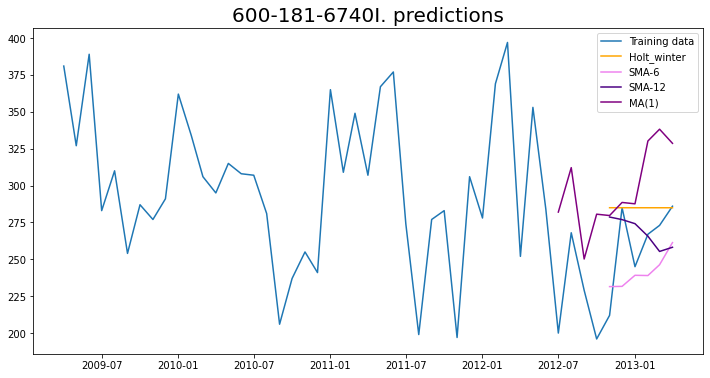

In [324]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var7['rescaled_forecast'][-len(predictions):],color='purple',label='MA(1)')
plt.legend();

In [41]:
Summary_ls.append('SMA-6')

<div class="alert alert-block alert-danger" >
For the variable '600-181-6740I.' we could achieve lower RMSE with  SMA model, but they are flat prediction, these models will have lower life span,  we can conclude tht ARIMA accounts better for the pattern of the data and would be appropriate for the variable.

### Variable 8:  07063-51210I.

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



07063-51210I.


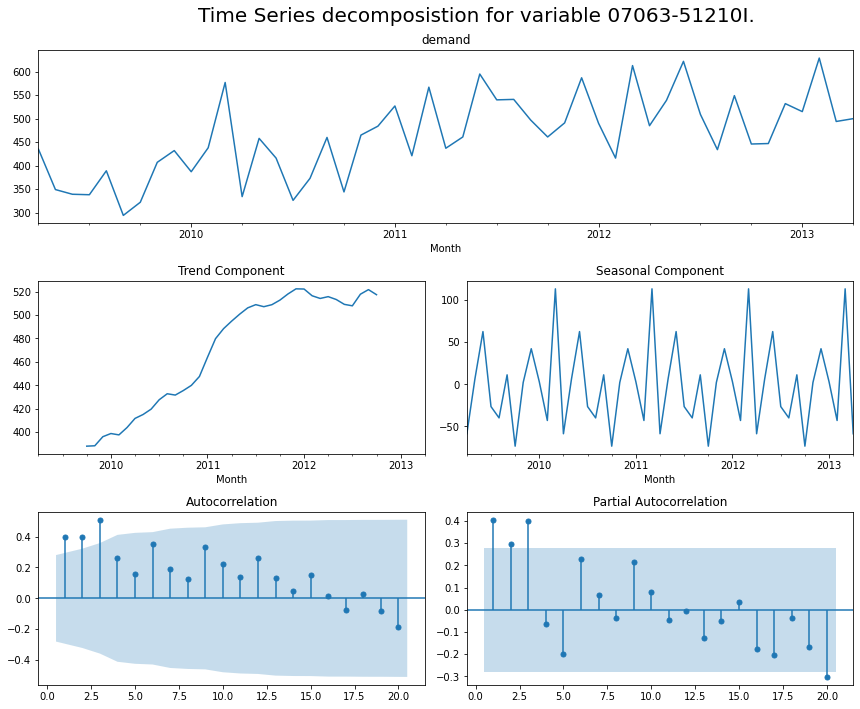

In [326]:
i=7
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- From the pattern observed above, an upward Trend seems to be present. Checking the other parameters to validate the same. Seasonality seems to be missing.
- ACF plot seems to be gradually decreasing but irregularities seem to be present. ACF and PACF have significant lag 1 values
- There is no significant vale for the 12th lag. Looks like seasonality does not exist.

In [327]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 07063-51210I. 


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             -1.72278        0.474931   
conclusion              non-stationary (unit root)  not stationary   
p-value                                   0.419417       0.0473129   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                       0.308054            0.01  
should we difference?             True            True

In [328]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 07063-51210I.:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [329]:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1st round of differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1st round of differencing on 07063-51210I.?


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -4.36141    0.121427         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 0.00034715         0.1   0.0239966         0.1
should we difference?        False       False       False       False

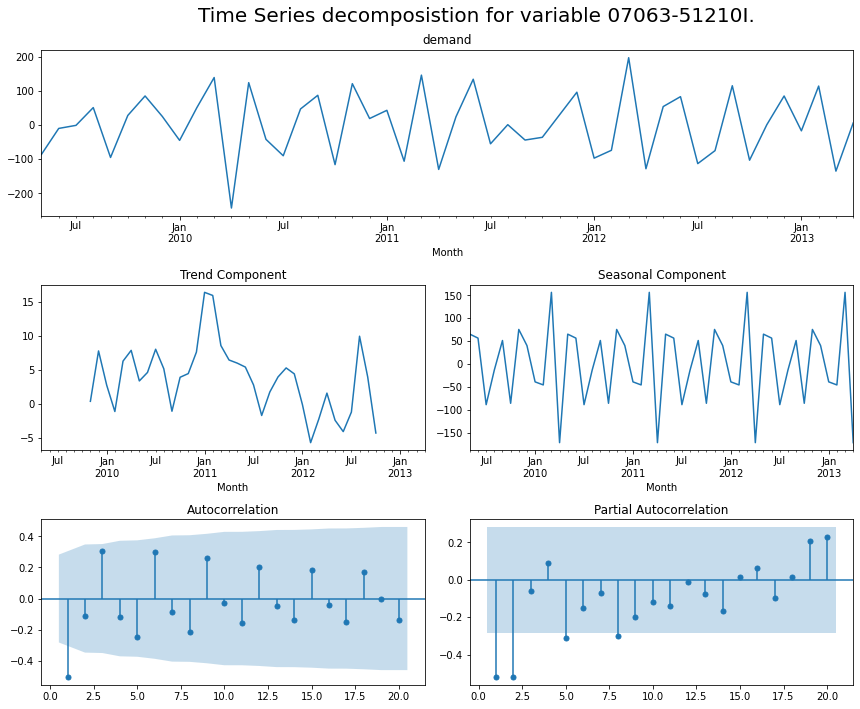

In [330]:
plot_stationarity(df_diff1,20)

The ACF now has few significant values after first differencing.

What about seasonality ?

In [331]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07063-51210I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

In [332]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df_diff1)


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df_diff1)


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07063-51210I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '07063-51210I..'has no seasonality. The time series has only trend and thus is a Non stationary time series.**


### Forecasting for variable '07063-51210I.'

In [333]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [335]:
best_RMSE,best_config

(55.52564222170151, [None, True, None, 12, True, True])

In [336]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

55.52564222170151 [None, True, None, 12, True, True]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        39.753
1                     Mean Squared Error:       522.452
2                Root Mean Squared Error:        55.526
3         Mean absolute percentage error:         7.436
4  Scaled Mean absolute percentage error:         7.519
5                    Mean forecast error:       516.759
6          Normalised mean squared error:         0.835
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [337]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var8=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var8

,Errors,Holts_winter,EWMA 0.22,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,39.753,39.167,44.140,61.999,45.528,39.792
1,Mean Squared Error:,522.452,522.452,522.452,522.452,522.452,522.452
2,Root Mean Squared Error:,55.526,57.718,63.033,79.347,55.401,51.855
3,Mean absolute percentage error:,7.436,7.134,7.935,11.149,8.460,7.466
4,Scaled Mean absolute percentage error:,7.519,7.403,8.404,12.133,8.688,7.537
5,Mean forecast error:,516.759,503.506,489.540,462.752,504.216,514.807
6,Normalised mean squared error:,0.835,0.903,1.077,1.706,0.832,0.729


In [276]:

series = df_diff1[:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(2, 0, 0) RMSE=70.037


predicted=-85.82, expected=-113.00
predicted=59.68, expected=-75.00
predicted=129.26, expected=115.00
predicted=-42.27, expected=-103.00
predicted=25.61, expected=1.00
predicted=60.50, expected=85.00
predicted=-63.13, expected=-17.00
predicted=-26.85, expected=114.00
predicted=-70.42, expected=-135.00
predicted=56.47, expected=6.00
Test RMSE: 72.567


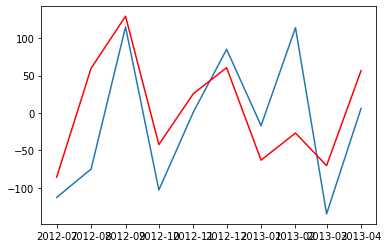

In [339]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [340]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -265.979
Date:                Tue, 17 May 2022   AIC                            539.958
Time:                        09:54:49   BIC                            547.358
Sample:                             0   HQIC                           542.743
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5557      4.463      0.797      0.426      -5.192      12.304
ar.L1         -0.7995      0.142     -5.639      0.000      -1.077      -0.522
ar.L2         -0.5239      0.131     -4.014      0.0

                0
count   47.000000
mean    -2.150700
std     70.170409
min   -130.121609
25%    -61.667993
50%    -12.425107
75%     50.103358
max    147.937862


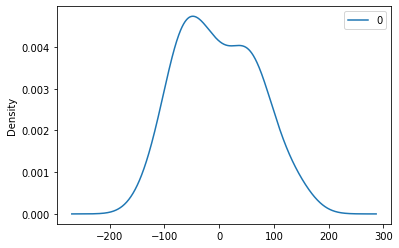

In [341]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

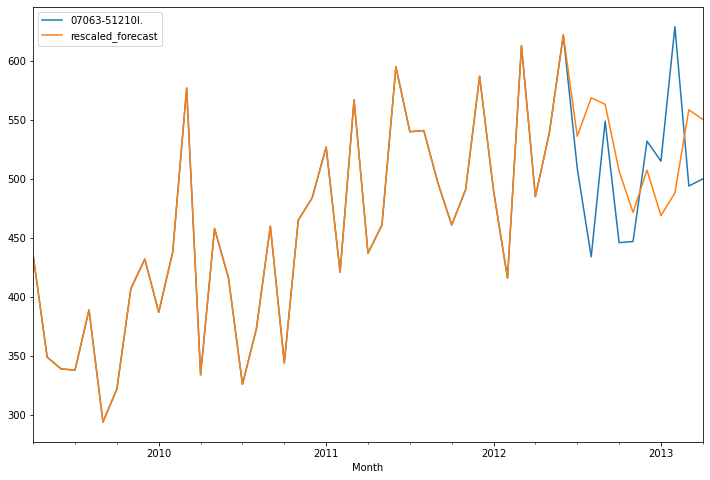

In [342]:
df_var8=pd.DataFrame(df[fc_ls1[i]])
df_var8['diff1']=df_var8.iloc[:,0].diff(1)
#df_var8['Sdiff1']=df_var8.iloc[:,0].diff(1).diff(12)
df_var8['forecast']=predictions
df_var8['forecast2']=pd.concat([train,predictions])
#df_var8['rescale_ARIMA']=df_var8['diff1'].cumsum()
df_var8['rescaled_forecast']= df_var8['forecast2']+df_var8[fc_ls1[i]].shift(1)
df_var8['rescaled_forecast'].iloc[:13]=df_var8[fc_ls1[i]].iloc[:13]
df_var8.drop('forecast2',inplace=True,axis=1)
df_var8
df_var8[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [343]:
error_var8=error_var8.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var8['rescaled_forecast'][-6:-1],'ARIMA'))
error_var8.set_index('Errors',inplace= True)
# multi index columns
error_var8.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var8.columns)])
error_var8

07063-51210I.                     \
                                        Holts_winter EWMA 0.22 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                          39.753    39.167   44.140   
Mean Squared Error:                          522.452   522.452  522.452   
Root Mean Squared Error:                      55.526    57.718   63.033   
Mean absolute percentage error:                7.436     7.134    7.935   
Scaled Mean absolute percentage error:         7.519     7.403    8.404   
Mean forecast error:                         516.759   503.506  489.540   
Normalised mean squared error:                 0.835     0.903    1.077   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     61.999   45.528   39.792   60.134  
Mean Squared Error:                     522.452  522.452  522.452  526.827  
Root Mean Squared Error:                 79.347   55.401   51.855   73.950  
Mean absolute percentage error:          11.149    8.460    7.466   10.907  
Scaled Mean absolute percentage error:   12.133    8.688    7.537   11.387  
Mean forecast error:                    462.752  504.216  514.807  500.021  
Normalised mean squared error:            1.706    0.832    0.729    1.215

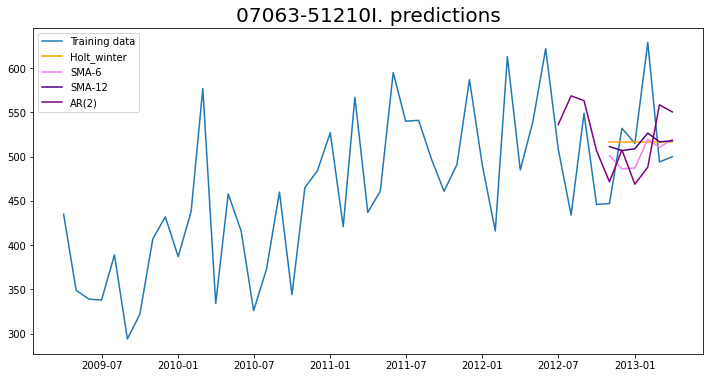

In [345]:
col_name= fc_ls1[i]
plt.figure(figsize=(12,6))
plt.title(col_name+" "+'predictions', size=20)
plt.plot(df[fc_ls1[i]], label='Training data')
#plt.plot(ts_v, color='gray', label='Testing data')
plt.plot(pred_HW, color='orange', label='Holt_winter')
# plt.plot(predictions2, color='green', label='auto_alpha_EWMA')
#plt.plot(predictions3, color='red', label='EWMA 0.4')
# plt.plot(predictions4, color='blue', label='EWMA 0.8')
plt.plot(df_pass_pred['SMA-6'][-6:],color='violet',label='SMA-6')
plt.plot(df_pass_pred['SMA-12'][-6:],color='indigo',label='SMA-12')
plt.plot(df_var8['rescaled_forecast'][-len(predictions):],color='purple',label='AR(2)')
plt.legend();

In [42]:
Summary_ls.append('AR(2)')

<div class="alert alert-block alert-danger" >
For the variable '07063-51210I.' we could suggest implementing AR(2) model

### Variable 9:  600-319-4540I..

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



600-319-4540I.


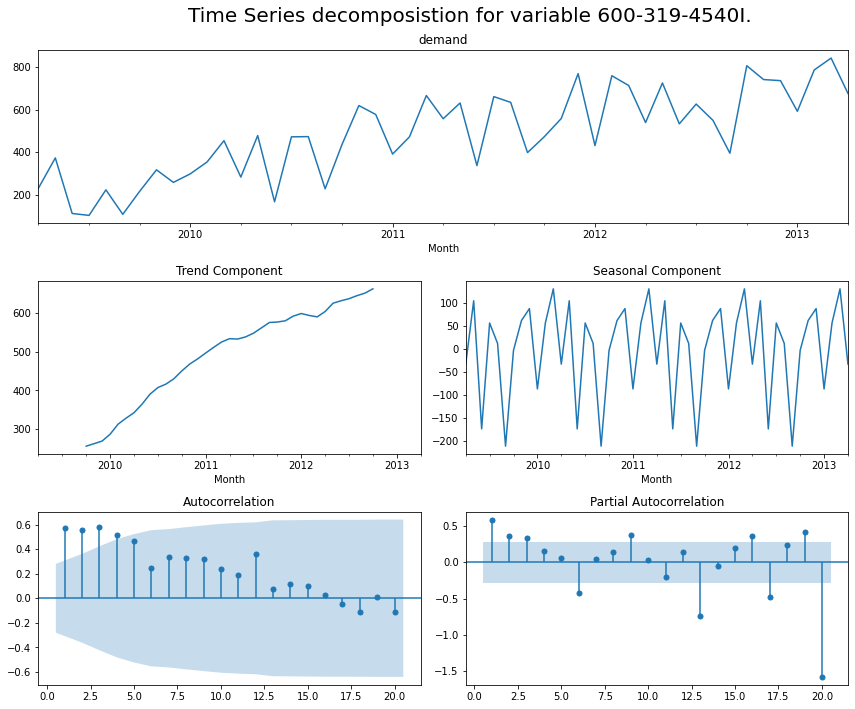

In [347]:
i=8
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Visually, it looks like there is an upward trend.
- There are significant lags at lag 1 for ACF and PACF and values at ACF are decaying slowly from lag 1. 
- There are no significant values at lag s in any of the graph.

In [359]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 600-319-4540I. 


Statsmodel                  \
                                               ADF            KPSS   
ADF statistic                             -2.65694         0.52462   
conclusion              non-stationary (unit root)  not stationary   
p-value                                  0.0817899       0.0361216   
should we difference?                         True            True   

                             PMD_model                  
                                   ADF            KPSS  
ADF statistic                      NaN             NaN  
conclusion              non-stationary  not stationary  
p-value                       0.252408            0.01  
should we difference?             True            True

In [360]:
# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
n_adf = pmd.arima.ndiffs(df[fc_ls1[i]], test="adf")
n_kpss = pmd.arima.ndiffs(df[fc_ls1[i]], test="kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print(f"recommended order of first differencing for original data variable {fc_ls1[i]}:")
[print(key, ":", value) for key,value in n_diffs.items()]

recommended order of first differencing for original data variable 600-319-4540I.:
ADF ndiff : 1
KPSS ndiff : 1


[None, None]

In [361]:

n_diff = max(n_adf, n_kpss)   
df_diff1 = df[fc_ls1[i]].diff(n_diff).dropna()
print(f"Stationary after 1st round of differencing on {fc_ls1[i]}?")
stationarity_check(df_diff1)

Stationary after 1st round of differencing on 600-319-4540I.?


Statsmodel               PMD_model            
                               ADF        KPSS         ADF        KPSS
ADF statistic             -3.92771    0.113541         NaN         NaN
conclusion              stationary  stationary  stationary  stationary
p-value                 0.00184015         0.1        0.01         0.1
should we difference?        False       False       False       False

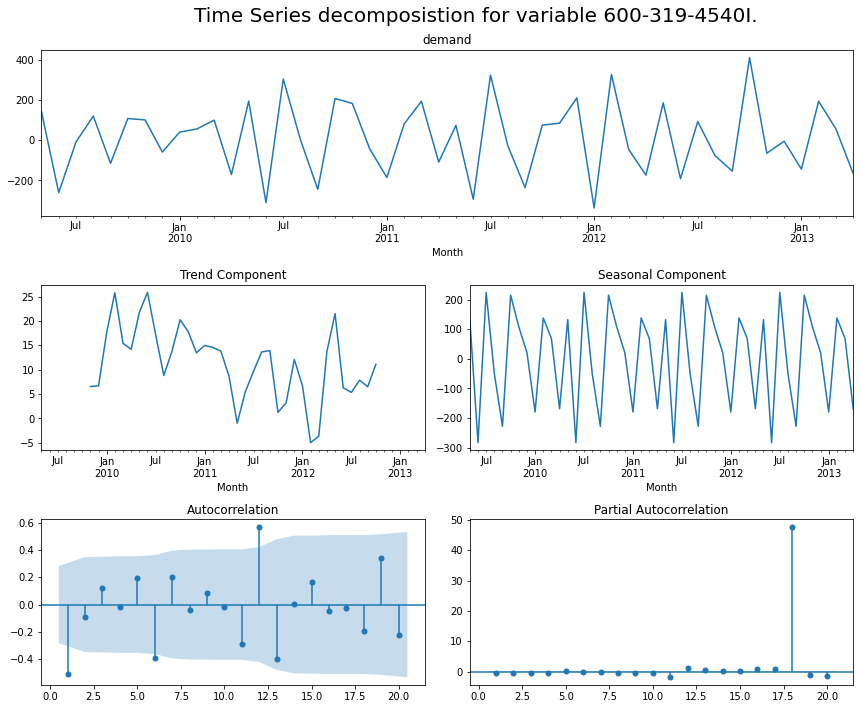

In [362]:
plot_stationarity(df_diff1,20)

ACF has fewer significant values after first differencing is applied.

What about seasonality ?

In [363]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 600-319-4540I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '600-319-4540I'has no seasonality after differencing and the series has only trend and no seasonality. We will optimize the ARIMA model to check if further differencing is required**


### Forecasting for variable '600-319-4540I.'

In [364]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [366]:
best_RMSE,best_config

(22.765068391005585, ['add', True, 'add', 12, False, False])

In [367]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

22.765068391005585 ['add', True, 'add', 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        15.442
1                     Mean Squared Error:       733.141
2                Root Mean Squared Error:        22.765
3         Mean absolute percentage error:         2.093
4  Scaled Mean absolute percentage error:         2.059
5                    Mean forecast error:       737.955
6          Normalised mean squared error:         0.069
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [368]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var9=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))
error_var9

,Errors,Holts_winter,EWMA 0.25,EWMA 0.4,EWMA 0.8,SMA-6,SMA-12
0,Mean Absolute Error:,15.442,124.002,112.065,62.674,87.556,100.347
1,Mean Squared Error:,733.141,733.141,733.141,733.141,733.141,733.141
2,Root Mean Squared Error:,22.765,141.861,127.414,79.378,92.780,115.745
3,Mean absolute percentage error:,2.093,16.155,14.675,8.988,11.808,13.181
4,Scaled Mean absolute percentage error:,2.059,17.957,16.058,8.730,12.431,14.259
5,Mean forecast error:,737.955,611.247,629.152,730.479,675.648,645.563
6,Normalised mean squared error:,0.069,2.663,2.148,0.834,1.139,1.773


In [369]:
# grid search ARIMA parameters for time series
series = df_diff1[:-6]
# evaluate parameters
p_values = range(0,15)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(7, 1, 2) RMSE=137.636


predicted=218.22, expected=93.00
predicted=-9.64, expected=-77.00
predicted=28.19, expected=-154.00
predicted=259.45, expected=411.00
predicted=-288.92, expected=-65.00
predicted=-147.78, expected=-5.00
predicted=30.42, expected=-144.00
predicted=184.21, expected=194.00
predicted=41.90, expected=56.00
predicted=-172.00, expected=-166.00
Test RMSE: 133.287


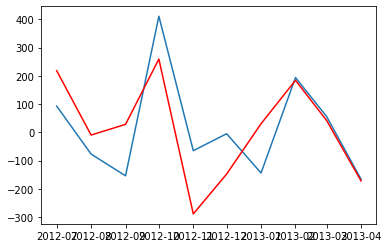

In [370]:
X=df_diff1
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [371]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -289.393
Date:                Tue, 17 May 2022   AIC                            598.786
Time:                        10:16:00   BIC                            617.072
Sample:                             0   HQIC                           605.636
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8991     24.430     -0.078      0.938     -49.781      45.983
ar.L2         -1.6919     21.960     -0.077      0.939     -44.733      41.349
ar.L3         -1.2062     19.369     -0.062      0.9

                0
count   47.000000
mean     9.463255
std    137.992911
min   -395.056997
25%    -71.981585
50%     12.867172
75%    112.761494
max    263.845953


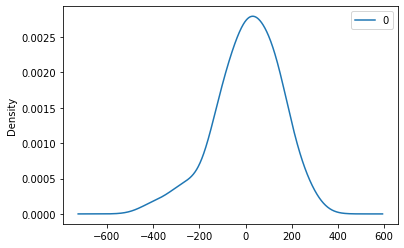

In [372]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

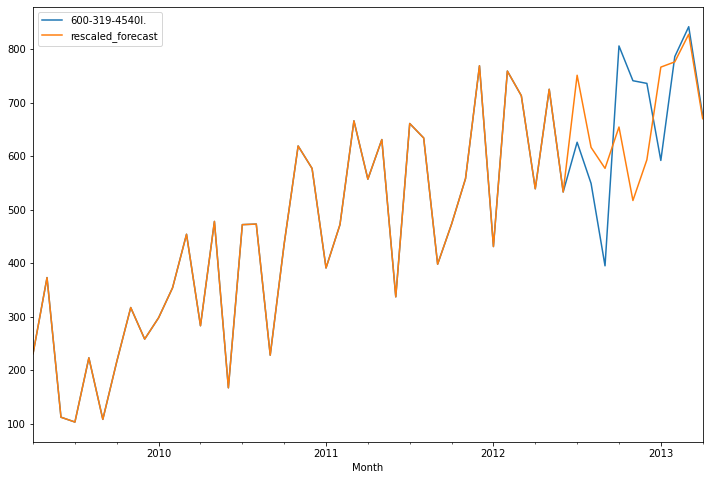

In [373]:
df_var9=pd.DataFrame(df[fc_ls1[i]])
df_var9['diff1']=df_var9.iloc[:,0].diff(1)
#df_var9['Sdiff1']=df_var9.iloc[:,0].diff(1).diff(12)
df_var9['forecast']=predictions
df_var9['forecast2']=pd.concat([train,predictions])
#df_var9['rescale_ARIMA']=df_var9['diff1'].cumsum()
df_var9['rescaled_forecast']= df_var9['forecast2']+df_var9[fc_ls1[i]].shift(1)
df_var9['rescaled_forecast'].iloc[:13]=df_var9[fc_ls1[i]].iloc[:13]
df_var9.drop('forecast2',inplace=True,axis=1)
df_var9
df_var9[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [374]:
error_var9=error_var9.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var9['rescaled_forecast'][-6:-1],'ARIMA'))
error_var9.set_index('Errors',inplace= True)
# multi index columns
error_var9.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var9.columns)])
error_var9

600-319-4540I.                     \
                                         Holts_winter EWMA 0.25 EWMA 0.4   
Errors                                                                     
Mean Absolute Error:                           15.442   124.002  112.065   
Mean Squared Error:                           733.141   733.141  733.141   
Root Mean Squared Error:                       22.765   141.861  127.414   
Mean absolute percentage error:                 2.093    16.155   14.675   
Scaled Mean absolute percentage error:          2.059    17.957   16.058   
Mean forecast error:                          737.955   611.247  629.152   
Normalised mean squared error:                  0.069     2.663    2.148   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                     62.674   87.556  100.347  113.003  
Mean Squared Error:                     733.141  733.141  733.141  744.043  
Root Mean Squared Error:                 79.378   92.780  115.745  142.298  
Mean absolute percentage error:           8.988   11.808   13.181   16.400  
Scaled Mean absolute percentage error:    8.730   12.431   14.259   17.141  
Mean forecast error:                    730.479  675.648  645.563  706.344  
Normalised mean squared error:            0.834    1.139    1.773    2.352

In [43]:
Summary_ls.append('HOLTS-WINTER')

<div class="alert alert-block alert-danger" >
For the variable '600-319-4540I.' we could achieve lower RMSE with  Holts-winter model 

### Variable 10: '6735-51-5143I'. 

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



6735-51-5143I


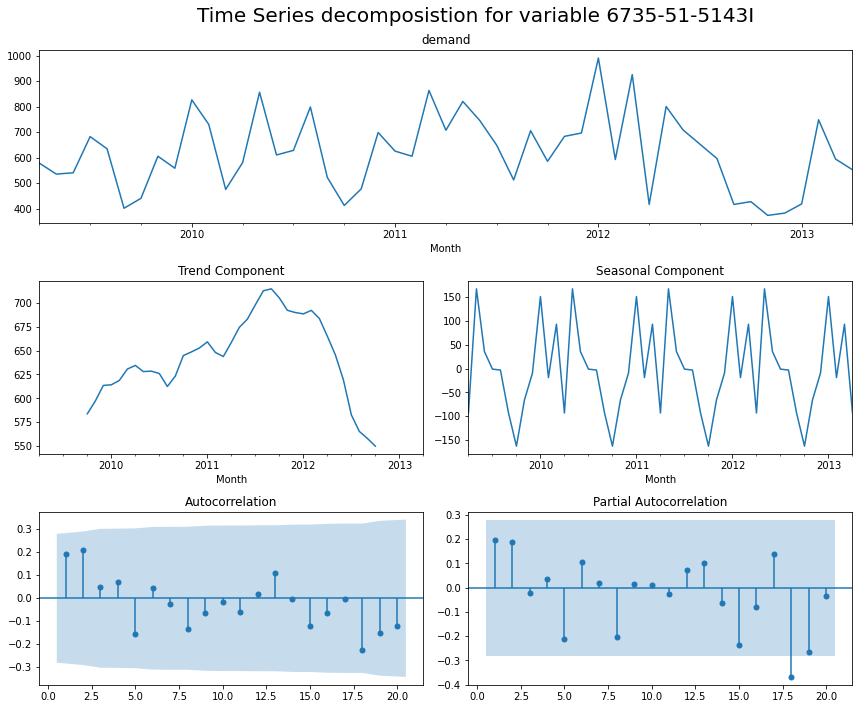

In [45]:
i=9
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Visually, it looks like there is no trend or seasonality.
- Since there are no lags outside the significant lines and no error terms , we can say the variable doesn’t have trend or seasonality and the model is stationary without any error terms.

In [46]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])

Stationarity test results for original data on 6735-51-5143I 


Statsmodel                   PMD_model            
                               ADF        KPSS             ADF        KPSS
ADF statistic             -3.52004    0.137698             NaN         NaN
conclusion              stationary  stationary  non-stationary  stationary
p-value                 0.00748702         0.1         0.33123         0.1
should we difference?        False       False            True       False

onnly PMD statistics is not significant, from the ACF and PACF plot, since there are no lag terms outside the significance boundary , we can say the series doesn’t have trend or seasonality and the model is stationary without any error terms. What about seasonality ?

In [47]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 6735-51-5143I -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '6735-51-5143I'has no seasonality.**


### Forecasting for variable '6735-51-5143I'

In [48]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [50]:
best_RMSE,best_config

(148.87350562779412, ['mul', True, None, 12, False, False])

In [51]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

148.87350562779412 ['mul', True, None, 12, False, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:       136.438
1                     Mean Squared Error:       528.649
2                Root Mean Squared Error:       148.874
3         Mean absolute percentage error:        27.161
4  Scaled Mean absolute percentage error:        26.652
5                    Mean forecast error:       496.206
6          Normalised mean squared error:         1.016
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [52]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var10=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))


In [53]:
# grid search ARIMA parameters for time series
series = df[fc_ls1[i]][:-6]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 0, 0) RMSE=168.718


predicted=646.41, expected=652.00
predicted=646.55, expected=596.00
predicted=645.32, expected=416.00
predicted=639.86, expected=427.00
predicted=634.91, expected=373.00
predicted=628.95, expected=382.00
predicted=623.47, expected=418.00
predicted=619.00, expected=748.00
predicted=621.74, expected=594.00
predicted=621.17, expected=552.00
Test RMSE: 171.603


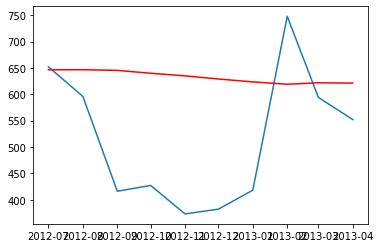

In [54]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [55]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                          ARIMA   Log Likelihood                -308.385
Date:                Tue, 17 May 2022   AIC                            620.770
Time:                        15:11:32   BIC                            624.512
Sample:                             0   HQIC                           622.184
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        621.1667     22.072     28.143      0.000     577.906     664.427
sigma2      2.226e+04   5339.989      4.168      0.000    1.18e+04    3.27e+04
Ljung-Box (L1) (Q):                   1.89   Jarque-

                0
count   48.000000
mean     0.000007
std    150.847723
min   -248.166659
25%   -101.666659
50%    -13.666659
75%     86.083341
max    368.833341


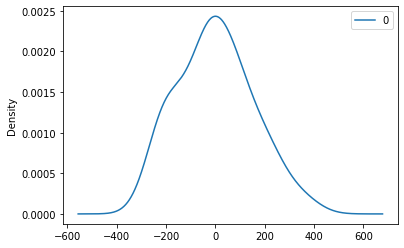

In [56]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

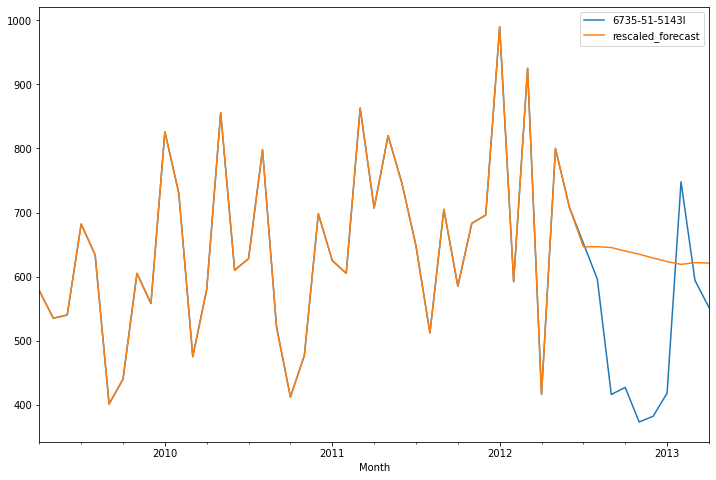

In [59]:
df_var10=pd.DataFrame(df[fc_ls1[i]])
#df_var10['diff1']=df_var10.iloc[:,0]#.diff(1)
#df_var10['Sdiff1']=df_var10.iloc[:,0].diff(1).diff(12)
df_var10['forecast']=predictions
df_var10['forecast2']=pd.concat([train,predictions])
#df_var10['rescale_ARIMA']=df_var10['diff1'].cumsum()
df_var10['rescaled_forecast']= df_var10['forecast2']#+df_var10[fc_ls1[i]].shift(1)
df_var10['rescaled_forecast'].iloc[:13]=df_var10[fc_ls1[i]].iloc[:13]
df_var10.drop('forecast2',inplace=True,axis=1)
df_var10
df_var10[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [60]:
error_var10=error_var10.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var10['rescaled_forecast'][-6:-1],'ARIMA'))
error_var10.set_index('Errors',inplace= True)
# multi index columns
error_var10.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var10.columns)])
error_var10

6735-51-5143I                     \
                                        Holts_winter EWMA 0.07 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                         136.438   162.755  120.167   
Mean Squared Error:                          528.649   528.649  528.649   
Root Mean Squared Error:                     148.874   184.346  134.993   
Mean absolute percentage error:               27.161    37.881   24.041   
Scaled Mean absolute percentage error:        26.652    30.181   23.422   
Mean forecast error:                         496.206   636.883  504.518   
Normalised mean squared error:                 1.016     1.558    0.835   

                                                                            
                                       EWMA 0.8    SMA-6   SMA-12    ARIMA  
Errors                                                                      
Mean Absolute Error:                    120.167  116.194  142.389  174.215  
Mean Squared Error:                     528.649  528.649  528.649  523.854  
Root Mean Squared Error:                156.076  146.078  168.877  194.530  
Mean absolute percentage error:          20.612   22.219   32.433   41.187  
Scaled Mean absolute percentage error:   23.296   22.417   26.993   32.744  
Mean forecast error:                    432.548  484.412  579.037  625.641  
Normalised mean squared error:            1.117    0.978    1.307    1.414

In [64]:
Summary_ls.append('EWMA_0.8')

<div class="alert alert-block alert-danger" >
EWMA-0.8 is achieving a MAPE of 20%. The spare '6735-51-5143I' can be forecasted using EWMA_0.8

### Variable 11: '07000-B2011I.' 

##### Step 1a: Identify stationary or nonstationary by checking trend and seasonality in the time series



07000-B2011I.


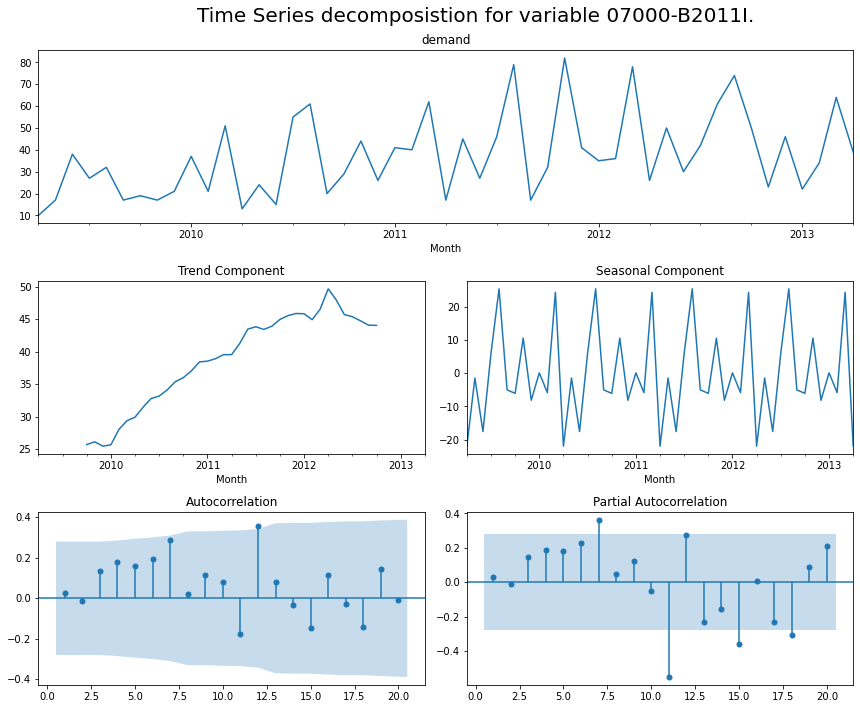

In [65]:
i=10
print(fc_ls1[i])
plot_stationarity(df[fc_ls1[i]],20)

The shaded area represents the upper and lower bounds for critical values, where the null hypothesis cannot be rejected ( auto correlation value is 0). 

So, from the above figure: 
- Since, there are no lags at lag 1 and there is no decaying pattern, we can conclude that the model is stationary and there is no trend and seasonality. 
- From the above plot we can see that p=11 and we will check for different model s with different p values.

In [66]:
# pmdarima - ADF test - should we difference?
# ADF null hypothesis: the series is not stationary 

# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable

#pmdarima - KPSS test -  should we difference?
# null hypothesis: the series is at least trend stationary 

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable

# compare ADF and KPSS result
print(f"Stationarity test results for original data on {fc_ls1[i]} ")
stationarity_check(df[fc_ls1[i]])['Statsmodel']

Stationarity test results for original data on 07000-B2011I. 


,ADF,KPSS
ADF statistic,-6.75673,0.455197
conclusion,stationary,stationary
p-value,2.85927e-09,0.0533634
should we difference?,False,False


What about seasonality ?

In [67]:
#for original data 
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = pmd.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# CH test that returns the recommended order of seasonal differencing:
n_ch = pmd.arima.CHTest(m=12).estimate_seasonal_differencing_term(df[fc_ls1[i]])


# seasonal differencing recommendation:
print(f"time series before first differencing for {fc_ls1[i]} -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()]

time series before first differencing for 07000-B2011I. -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 0


[None, None, None]

**After seasonality check, it is found the varibale '07000-B2011I.'has no seasonality after differencing and before.**


### Forecasting for variable '07000-B2011I.'

In [223]:
cfg_list = exp_smoothing_configs(seasonal=[12])

In [69]:
best_RMSE,best_config

(16.662034839684946, [None, True, None, 12, True, False])

In [70]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('2012-01-01'), end = pd.to_datetime('2013-03-01'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([df, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW,'Holts_winter'))
print('-*-'*20)
var_ldf= model_eval(ts_v, pred_HW,'Holts_winter')

16.662034839684946 [None, True, None, 12, True, False]
                                   Errors  Holts_winter
0                    Mean Absolute Error:        14.296
1                     Mean Squared Error:        40.624
2                Root Mean Squared Error:        16.662
3         Mean absolute percentage error:        49.519
4  Scaled Mean absolute percentage error:        36.676
5                    Mean forecast error:        46.443
6          Normalised mean squared error:         1.121
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


In [71]:

model2 = SimpleExpSmoothing(ts).fit() # automatic alpha selection
predictions2 = model2.forecast(steps=6)
alpha=str(round(model2.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions2,'EWMA'+' '+alpha))
model3 = SimpleExpSmoothing(ts).fit(smoothing_level=0.4,optimized=False) # alpha =0.4
predictions3 = model3.forecast(steps=6)
alpha=str(round(model3.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions3,'EWMA'+' '+alpha))
model4 = SimpleExpSmoothing(ts).fit(smoothing_level=0.8,optimized=False) # alpha =0.8
predictions4 = model4.forecast(steps=6)
alpha=str(round(model4.model.params['smoothing_level'],2))
var_ldf=var_ldf.merge(model_eval(ts_v, predictions4,'EWMA'+' '+alpha))
var_ldf

df_pass_pred['SMA-6'] = df_pass_pred[fc_ls1[i]].rolling(window=6).mean()
df_pass_pred['SMA-12'] = df_pass_pred[fc_ls1[i]].rolling(window=12).mean()
# df_pass_pred['EWMA-0.4'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.4).mean()
# df_pass_pred['EWMA-0.8'] = df_pass_pred['205-70-N1190'].ewm(alpha=0.8).mean()

error_var11=var_ldf.merge(model_eval(ts_v, df_pass_pred['SMA-6'][-6:],'SMA-6'))\
.merge(model_eval(ts_v, df_pass_pred['SMA-12'][-6:],'SMA-12'))


In [72]:
# grid search ARIMA parameters for time series
series = df[fc_ls1[i]]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10,11,12]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(0, 1, 1) RMSE=17.538


predicted=42.48, expected=42.00
predicted=42.41, expected=61.00
predicted=44.92, expected=74.00
predicted=49.30, expected=50.00
predicted=49.40, expected=23.00
predicted=45.44, expected=46.00
predicted=45.51, expected=22.00
predicted=42.50, expected=34.00
predicted=41.42, expected=64.00
predicted=44.24, expected=39.00
Test RMSE: 17.469


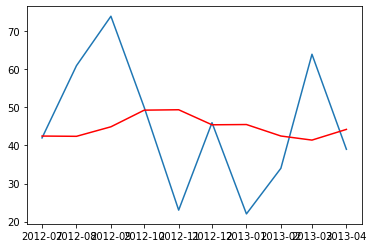

In [84]:
X=df[fc_ls1[i]]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(round(float(yhat),3))
    obs = test[t]
    history.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
predictions=pd.Series(predictions)
predictions.index=test.index
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [85]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -203.848
Date:                Tue, 17 May 2022   AIC                            411.696
Time:                        15:27:00   BIC                            415.396
Sample:                             0   HQIC                           413.089
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8770      0.086    -10.207      0.000      -1.045      -0.709
sigma2       332.0830     76.273      4.354      0.000     182.590     481.576
Ljung-Box (L1) (Q):                   1.85   Jarque-

               0
count  48.000000
mean    4.447120
std    17.851842
min   -25.433214
25%    -7.893899
50%     0.177196
75%    14.074031
max    44.414497


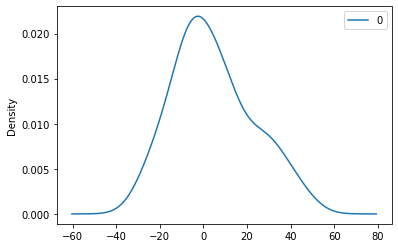

In [86]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Month'>

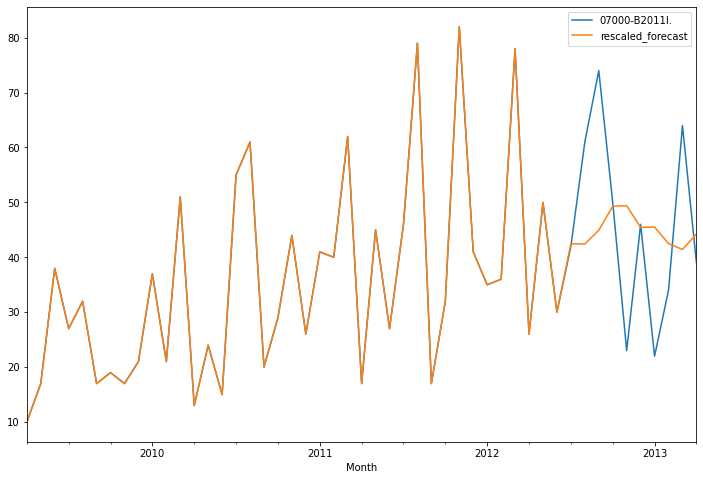

In [87]:
df_var11=pd.DataFrame(df[fc_ls1[i]])
#df_var11['diff1']=df_var11.iloc[:,0]#.diff(1)
#df_var11['Sdiff1']=df_var11.iloc[:,0].diff(1).diff(12)
df_var11['forecast']=predictions
df_var11['forecast2']=pd.concat([train,predictions])
#df_var11['rescale_ARIMA']=df_var11['diff1'].cumsum()
df_var11['rescaled_forecast']= df_var11['forecast2']#+df_var11[fc_ls1[i]].shift(1)
df_var11['rescaled_forecast'].iloc[:13]=df_var11[fc_ls1[i]].iloc[:13]
df_var11.drop('forecast2',inplace=True,axis=1)
df_var11
df_var11[[fc_ls1[i],'rescaled_forecast']].plot(figsize=(12,8))

In [88]:
error_var11=error_var11.merge(model_eval(df[fc_ls1[i]][-6:-1],df_var11['rescaled_forecast'][-6:-1],'ARIMA'))
error_var11.set_index('Errors',inplace= True)
# multi index columns
error_var11.columns=pd.MultiIndex.from_tuples([i for i in zip([fc_ls1[i] for x in range(7)],error_var11.columns)])
error_var11

07000-B2011I.                     \
                                        Holts_winter EWMA 0.13 EWMA 0.4   
Errors                                                                    
Mean Absolute Error:                          14.296    15.893   20.215   
Mean Squared Error:                           40.624    40.624   40.624   
Root Mean Squared Error:                      16.662    17.995   22.504   
Mean absolute percentage error:               49.519    55.513   71.732   
Scaled Mean absolute percentage error:        36.676    39.800   47.338   
Mean forecast error:                          46.443    48.839   55.323   
Normalised mean squared error:                 1.121     1.308    2.045   

                                                                         
                                       EWMA 0.8   SMA-6  SMA-12   ARIMA  
Errors                                                                   
Mean Absolute Error:                     19.409  13.944  13.694  16.309  
Mean Squared Error:                      40.624  40.624  40.624  40.941  
Root Mean Squared Error:                 21.587  17.265  16.293  19.143  
Mean absolute percentage error:          68.709  46.937  46.586  56.629  
Scaled Mean absolute percentage error:   46.025  35.756  35.470  41.770  
Mean forecast error:                     54.114  43.743  44.840  44.941  
Normalised mean squared error:            1.882   1.204   1.072   1.185

In [89]:
Summary_ls.append('SMA-12')

<div class="alert alert-block alert-danger" >
ARIMA is achieving a RMSE of 21, while HW is getting 16.6, for the vaiable '07000-B2011I.' we can opt for Holts- winter for this variable

In [90]:
Summary['Best_model']=Summary_ls

In [91]:
Summary

,Variable,Best_model
0,205-70-N1190,MA(1)
1,PC_198_27_42263,SMA-6
2,PC_203_32_51461,SMA-2
3,PC_600_863_4210,AR(8) and MA(2)
4,PC_6735_61_3410,ARMA(8)
5,D30141135,AR(6) and MA(2)
6,600-181-6740I.,SMA-6
7,07063-51210I.,AR(2)
8,600-319-4540I.,HOLTS-WINTER
9,6735-51-5143I,EWMA_0.8


The best models for different variables are as above. 

<div class="alert alert-block alert-danger" >
We recommend a strategic solution for 20,000 forecasting models to be built. It is to rationalize the demand for each spare part quantitatively and qualitatively.It is recommended to be done by identifying the high variance  variables i.e. the spare parts which are causing the highest variability in supply chain and in the revenue. Once, these have been identified the forecasting techniques discussed in the methodology can be executed in a short time